- 데이터셋 분석대상 기간 : <br>
2017-01-01 ~ 2018-08-31 (1년 8개월) <br>


- 출처 : <br>
https://www.kaggle.com/olistbr/brazilian-ecommerce <br>
https://www.kaggle.com/olistbr/marketing-funnel-olist


- 분석 주제 :<br>
 -> Olist 셀러, 판매월, 제품카테고리 중 평균 review_score가 낮은 건들을 확인하고<br>
 -> 해당 계정들에서 공통적으로 관찰되는 문제점을 파악하여 review_score 개선 전략을 세우자
 
 
- 분석 단계 :<br>
 -> 1단계 : 셀러별 월별 매출액, 판매횟수 및 기타 특징을 입력변수로 사용한 군집화 (등급)<br>
 -> 2단계 : 해당 등급 및 기타 특징을 입력변수로 사용한 review_score 예측<br>
 -> 3단계 : review_score에 영향을 미친 요인을 구체적으로 확인하기 위한 워드클라우드 확인

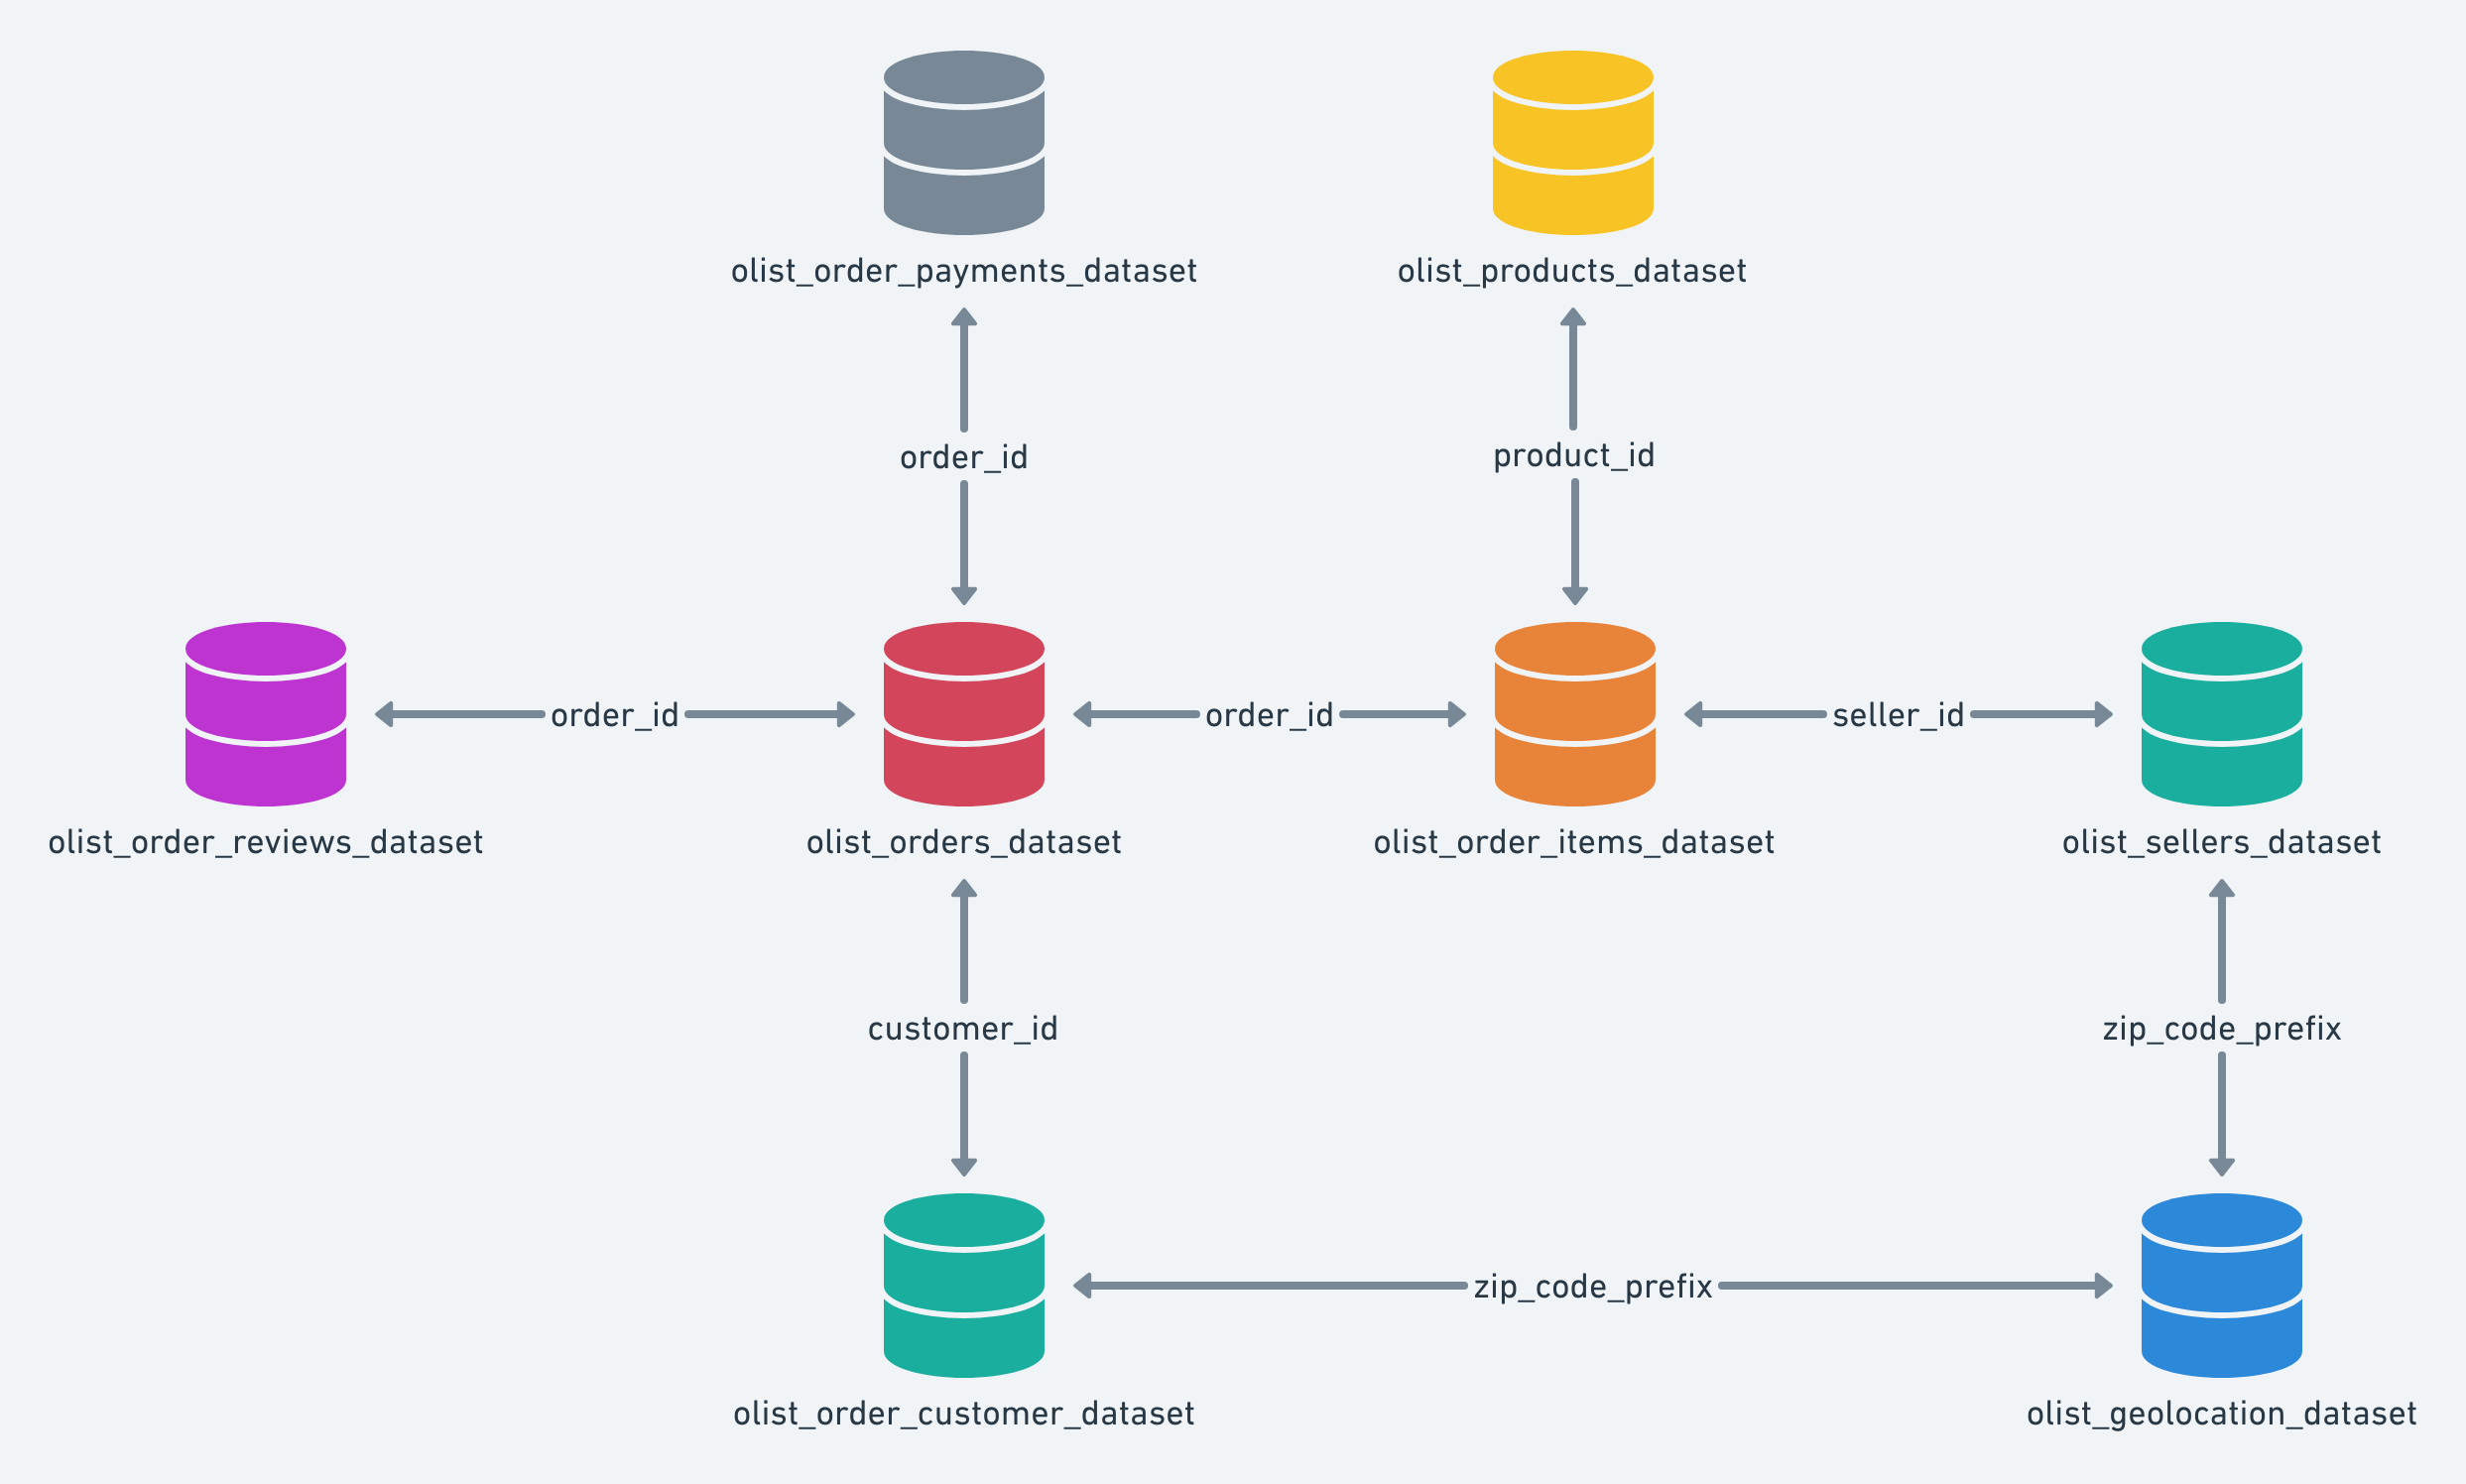

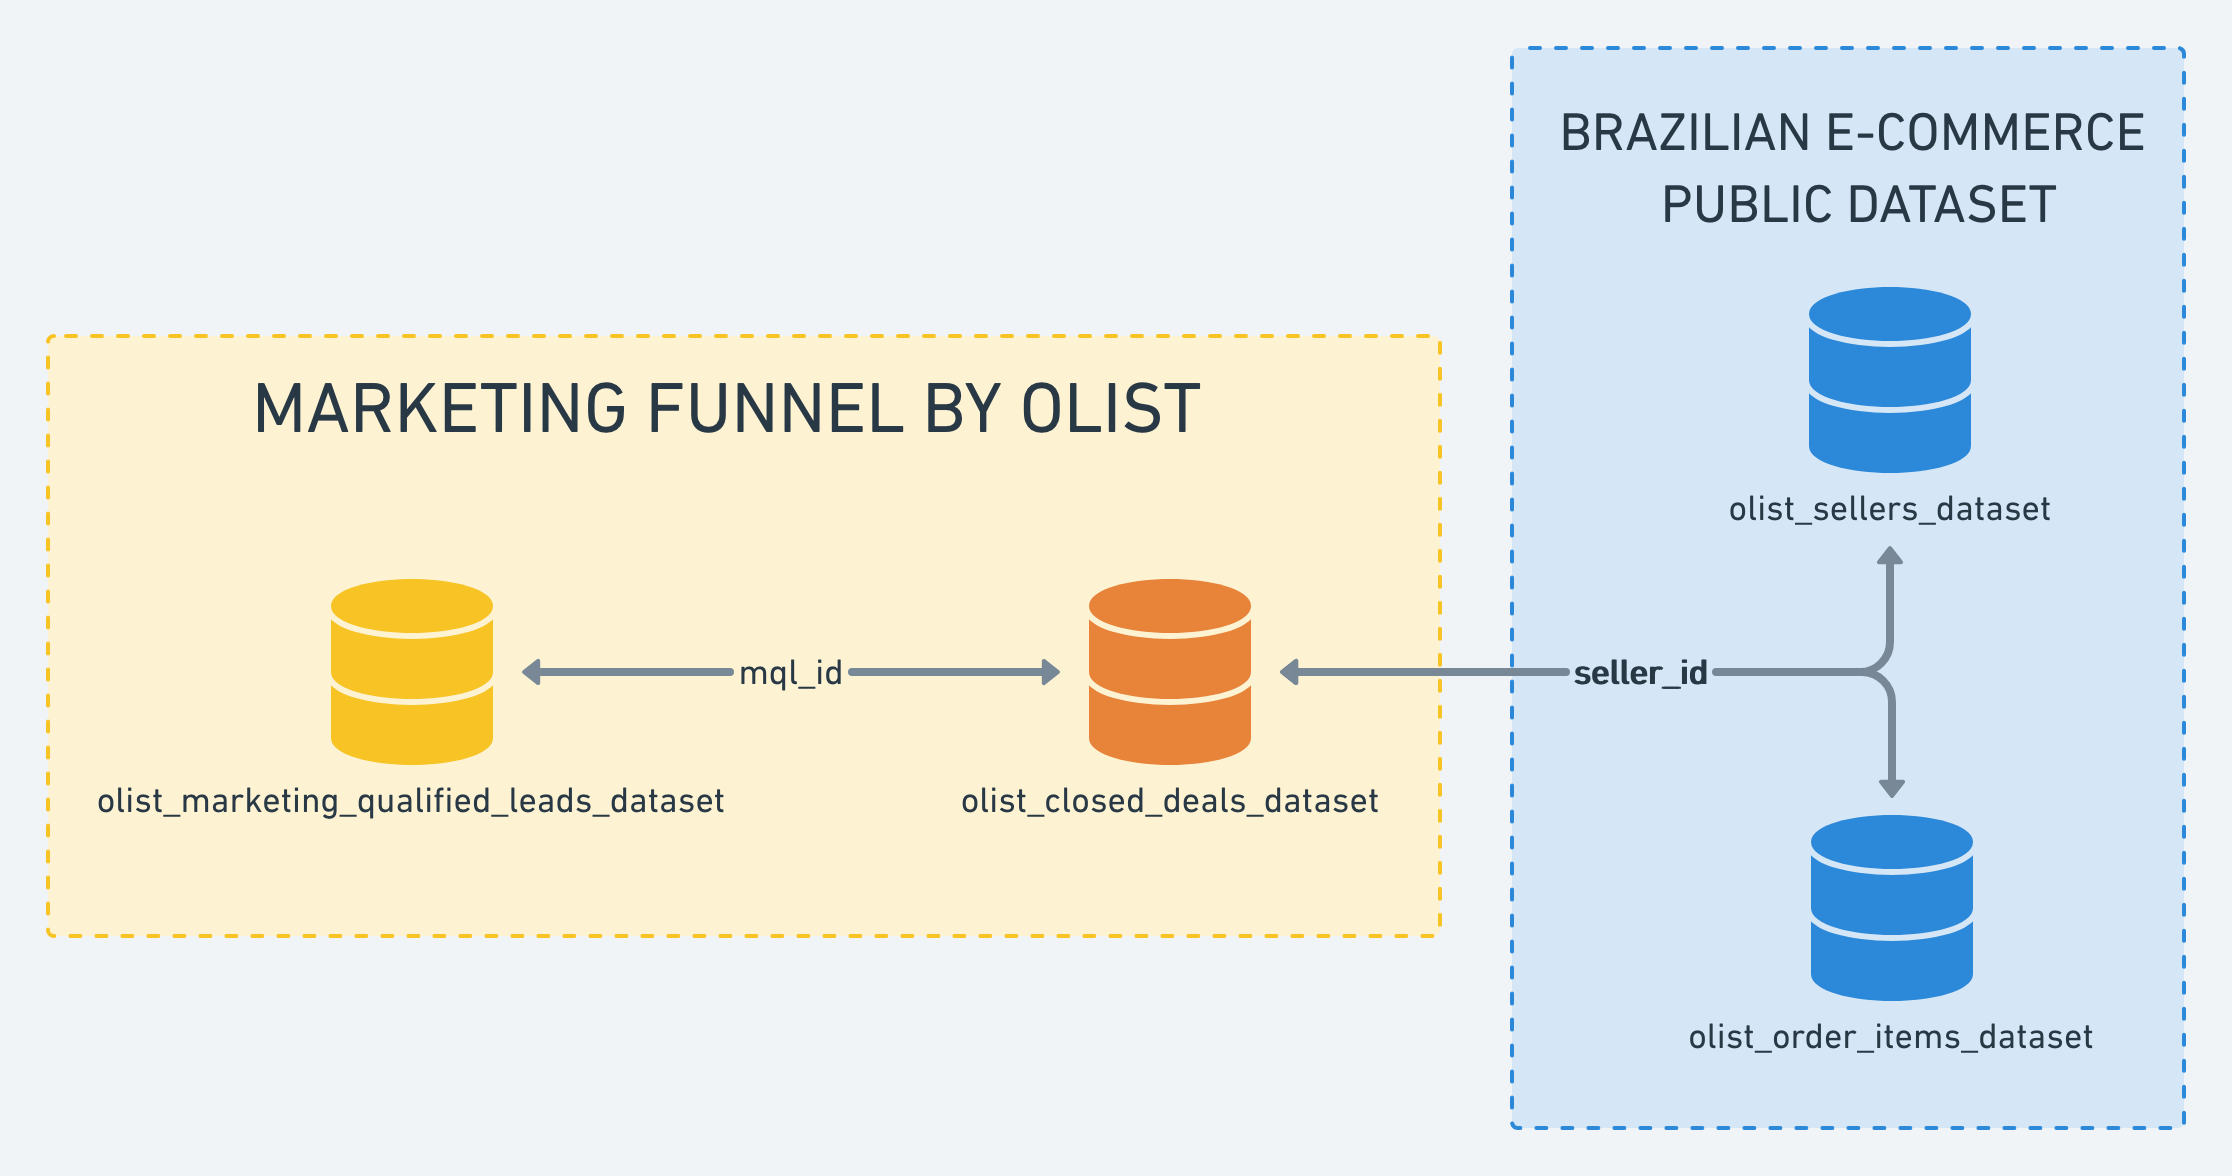

In [1004]:
%autosave 0

Autosave disabled


In [1005]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", -1)

# 데이터셋 불러오기

1) marketing_qualified_leads

In [1006]:
leads = pd.read_csv('olist_marketing_qualified_leads_dataset.csv')
leads.head(5)

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


In [1007]:
leads.shape

(8000, 4)

In [1008]:
leads.isnull().sum()

mql_id                0 
first_contact_date    0 
landing_page_id       0 
origin                60
dtype: int64

In [1009]:
leads.describe()

,mql_id,first_contact_date,landing_page_id,origin
count,8000,8000,8000,7940
unique,8000,336,495,10
top,99bc9f7d864b6291861728d671d61890,2018-05-02,b76ef37428e6799c421989521c0e5077,organic_search
freq,1,93,912,2296


2) closed_deals_dataset

In [1010]:
closed = pd.read_csv('olist_closed_deals_dataset.csv')
closed.head(1)

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0


In [1011]:
closed.shape

(842, 14)

In [1012]:
closed.isnull().sum()

mql_id                           0  
seller_id                        0  
sdr_id                           0  
sr_id                            0  
won_date                         0  
business_segment                 1  
lead_type                        6  
lead_behaviour_profile           177
has_company                      779
has_gtin                         778
average_stock                    776
business_type                    10 
declared_product_catalog_size    773
declared_monthly_revenue         0  
dtype: int64

In [1013]:
closed.describe()

,declared_product_catalog_size,declared_monthly_revenue
count,69.000000,8.420000e+02
mean,233.028986,7.337768e+04
std,352.380558,1.744799e+06
min,1.000000,0.000000e+00
25%,30.000000,0.000000e+00
50%,100.000000,0.000000e+00
75%,300.000000,0.000000e+00
max,2000.000000,5.000000e+07


In [1014]:
closed.describe(include = "O")

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type
count,842,842,842,842,842,841,836,665,63,64,66,832
unique,842,842,32,22,824,33,8,9,2,2,6,3
top,99bc9f7d864b6291861728d671d61890,0ca9bd8db4679bc89692acdfcd96b6c4,4b339f9567d060bcea4f5136b9f5949e,4ef15afb4b2723d8f3d81e51ec7afefe,2018-05-04 03:00:00,home_decor,online_medium,cat,True,True,5-20,reseller
freq,1,1,140,133,6,105,332,407,58,54,22,587


3) olist_sellers_dataset

In [1015]:
seller = pd.read_csv('olist_sellers_dataset.csv')
seller.head(1)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP


In [1016]:
seller.describe(include = 'O')

,seller_id,seller_city,seller_state
count,3095,3095,3095
unique,3095,611,23
top,91543f9849d68d023e17194926598543,sao paulo,SP
freq,1,694,1849


In [1017]:
seller.describe()

,seller_zip_code_prefix
count,3095.000000
mean,32291.059451
std,32713.453830
min,1001.000000
25%,7093.500000
50%,14940.000000
75%,64552.500000
max,99730.000000


4) olist_order_items_dataset

In [1018]:
item = pd.read_csv('olist_order_items_dataset.csv')
item

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [1019]:
item.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [1020]:
item.describe(include = 'O')

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23
freq,21,527,2033,21


In [1021]:
item[item['order_item_id'] > 10]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
11942,1b15974a0141d54e36626dca3fdc731a,11,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.00,10.12
11943,1b15974a0141d54e36626dca3fdc731a,12,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.00,10.12
11944,1b15974a0141d54e36626dca3fdc731a,13,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.00,10.12
11945,1b15974a0141d54e36626dca3fdc731a,14,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.00,10.12
11946,1b15974a0141d54e36626dca3fdc731a,15,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.00,10.12
...,...,...,...,...,...,...,...
75122,ab14fdcfbe524636d65ee38360e22ce8,20,9571759451b1d780ee7c15012ea109d4,ce27a3cc3c8cc1ea79d11e561e9bebb6,2017-08-30 14:30:23,98.70,14.44
77085,af822dacd6f5cff7376413c03a388bb7,11,62995b7e571f5760017991632bbfd311,98dac6635aee4995d501a3972e047414,2018-06-13 17:30:35,5.31,15.23
77086,af822dacd6f5cff7376413c03a388bb7,12,62995b7e571f5760017991632bbfd311,98dac6635aee4995d501a3972e047414,2018-06-13 17:30:35,5.31,15.23
84668,c05d6a79e55da72ca780ce90364abed9,11,710b7c26b7a742f497bba45fab91a25f,98dac6635aee4995d501a3972e047414,2018-05-17 13:31:00,21.15,5.54


In [1022]:
# 동일 셀러에게 동일 제품을 여러개 주문한 경우, 아래와 같이 나머지 데이터는 모두 같고 order_item_id만 다르게 표시됨
item[item['order_id'] == '1b15974a0141d54e36626dca3fdc731a']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
11932,1b15974a0141d54e36626dca3fdc731a,1,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11933,1b15974a0141d54e36626dca3fdc731a,2,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11934,1b15974a0141d54e36626dca3fdc731a,3,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11935,1b15974a0141d54e36626dca3fdc731a,4,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11936,1b15974a0141d54e36626dca3fdc731a,5,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11937,1b15974a0141d54e36626dca3fdc731a,6,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11938,1b15974a0141d54e36626dca3fdc731a,7,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11939,1b15974a0141d54e36626dca3fdc731a,8,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11940,1b15974a0141d54e36626dca3fdc731a,9,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11941,1b15974a0141d54e36626dca3fdc731a,10,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12


5) olist_orders_dataset

In [1023]:
order =  pd.read_csv('olist_orders_dataset.csv')
order.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [1024]:
order.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e1da6a380c23eec0e20231c7b695f47e,9e08d3d12c8694671a52867c2b9bb224,delivered,2017-11-20 11:46:30,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-07-24 21:36:42,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [1025]:
order.describe(include = 'O')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e1da6a380c23eec0e20231c7b695f47e,9e08d3d12c8694671a52867c2b9bb224,delivered,2017-11-20 11:46:30,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-07-24 21:36:42,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


6) olist_products_dataset

In [1026]:
product = pd.read_csv('olist_products_dataset.csv')
product

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [1027]:
product.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [1028]:
product.describe(include = 'O')

,product_id,product_category_name
count,32951,32341
unique,32951,73
top,692ac900c71e8e83e8ff029083018179,cama_mesa_banho
freq,1,3029


7) product_category_name_translation

In [1029]:
name = pd.read_csv('product_category_name_translation.csv')
name.head(1)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty


8) olist_geolocation_dataset

In [1030]:
geo = pd.read_csv('olist_geolocation_dataset.csv')
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


9) olist_order_reviews_dataset

In [1031]:
review = pd.read_csv('olist_order_reviews_dataset.csv')
review.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53


In [1032]:
review['review_score'].count()

100000

In [1033]:
review.describe(include = 'O')

,review_id,order_id,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,100000,100000,11715,41753,100000,100000
unique,99173,99441,4600,36921,637,99010
top,2172867fd5b1a55f98fe4608e1547b4b,c88b1d1b157a9999ce368f218a407141,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,426,230,466,4


# EDA 및 데이터 통합

## item 데이터셋 전처리

In [1034]:
# price(제품 가격)과 freight_value(배송비)를 더한 'revenue' 컬럼 생성
item['revenue'] = item['price'] + item['freight_value']
item

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,revenue
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,218.04
...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,343.40
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,386.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,116.85
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,64.71


In [1035]:
# 동일 셀러에게 동일 제품을 여러개 주문한 경우의 데이터 합치기
item = item.groupby(["order_id","product_id","seller_id","shipping_limit_date","price","freight_value"]).agg(
    {"order_item_id" : "count", "revenue" : "sum"}).reset_index().rename(columns = {"order_item_id" : "num"})
item

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,72.19
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1,259.83
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1,216.87
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1,218.04
...,...,...,...,...,...,...,...,...
102420,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,1,343.40
102421,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,1,386.53
102422,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,1,116.85
102423,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,1,64.71


## seller_id x order_id

### 셀러별 판매건수 확인

In [1036]:
# 전체 셀러 : 3095명
seller_order = item.groupby('seller_id')['order_id'].agg('count').sort_values(ascending = False)
seller_order = seller_order.reset_index()
seller_order

,seller_id,order_id
0,6560211a19b47992c3666cc44a7e94c0,1982
1,4a3ca9315b744ce9f8e9374361493884,1889
2,cc419e0650a3c5ba77189a1882b7556a,1720
3,1f50f920176fa81dab994f9023523100,1473
4,da8622b14eb17ae2831f4ac5b9dab84a,1438
...,...,...
3090,75fdd0a732287f9497b179f6bd445d32,1
3091,b9de031b671cd48b28fae9d828cbf2b4,1
3092,24c1de8d9551c0b4fbc53317d53efda8,1
3093,ba8e85df286308fe68a2ce83a8f8b2d6,1


In [1037]:
# 판매를 2건 이상 한 셀러 : 2532명
seller_order[seller_order['order_id']>1]

,seller_id,order_id
0,6560211a19b47992c3666cc44a7e94c0,1982
1,4a3ca9315b744ce9f8e9374361493884,1889
2,cc419e0650a3c5ba77189a1882b7556a,1720
3,1f50f920176fa81dab994f9023523100,1473
4,da8622b14eb17ae2831f4ac5b9dab84a,1438
...,...,...
2527,4eeb99008a0f59d2c7759c59f9a346eb,2
2528,63272377184e969942f7fff221be858d,2
2529,78ba5933c21686d1c2f64669c8c459e7,2
2530,6c9875b2f94ba781186f0c1aed8d1687,2


array([[<AxesSubplot:title={'center':'order_id'}>]], dtype=object)

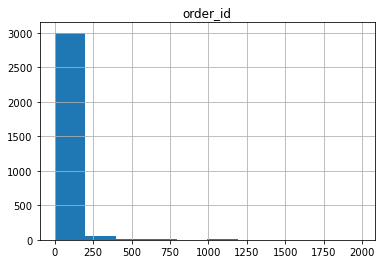

In [1038]:
# 전체 셀러 판매건수 분포 확인
seller_order.hist()

array([[<AxesSubplot:title={'center':'order_id'}>]], dtype=object)

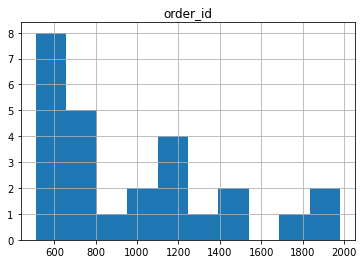

In [1039]:
# 판매 건수가 500 이상인 셀러 판매건수 분포 확인
seller_order[seller_order['order_id']>500].hist()

In [1040]:
# 전체 셀러 중 2건 이상 판매한 셀러 비율 : 약 81.8%
seller_order[seller_order['order_id']>1].shape[0] / seller_order.shape[0]

0.8180936995153474

### 주문별 판매 아이템수(num) 확인

In [1041]:
# 주문별 판매 아이템수는 1~8개 사이에 분포
seller_orderitem = item.groupby('order_id')['num'].count().sort_values(ascending = False)
seller_orderitem = seller_orderitem.reset_index()
seller_orderitem

,order_id,num
0,ca3625898fbd48669d50701aba51cd5f,8
1,7d8f5bfd5aff648220374a2df62e84d5,7
2,77df84f9195be22a4e9cb72ca9e8b4c2,7
3,ad850e69fce9a512ada84086651a2e7d,7
4,3990f96693d321ac142fff312bf3706a,6
...,...,...
98661,a9d9773efe0a981195d2861250cff4d9,1
98662,a9d9e48bc0905664f33c53779b5edfb6,1
98663,a9da0d64f6c4dff3f3f383f6b076b24a,1
98664,a9da66f1dfe4cca8956f5e74619c2cb9,1


In [1042]:
# 동일 order_id에 다양한 product_id, seller_id가 있는 경우
item[item['order_id']=='ca3625898fbd48669d50701aba51cd5f']

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue
80867,ca3625898fbd48669d50701aba51cd5f,0cf2faf9749f53924cea652a09d8e327,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,33.9,1.84,1,35.74
80868,ca3625898fbd48669d50701aba51cd5f,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,159.0,3.67,2,325.34
80869,ca3625898fbd48669d50701aba51cd5f,1065e0ebef073787a7bf691924c60eeb,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,309.0,1.84,1,310.84
80870,ca3625898fbd48669d50701aba51cd5f,21b524c4c060169fa75ccf08c7da4627,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,63.7,0.15,1,63.85
80871,ca3625898fbd48669d50701aba51cd5f,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,56.0,3.68,2,119.36
80872,ca3625898fbd48669d50701aba51cd5f,4a5c3967bfd3629fe07ef4d0cc8c3818,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,109.9,0.15,1,110.05
80873,ca3625898fbd48669d50701aba51cd5f,5dae498eff2d80057f56122235a36aff,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15,1,96.05
80874,ca3625898fbd48669d50701aba51cd5f,678c229b41c0e497d35a25a8be1cc631,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15,1,96.05


In [1043]:
# 같은 셀러에게 같은 아이템을 여러개 구매한 경우 아래와 같이 'num' 컬럼에 표시됨
item[item['order_id']=='428a2f660dc84138d969ccd69a0ab6d5']

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue
26550,428a2f660dc84138d969ccd69a0ab6d5,89b190a046022486c635022524a974a8,f326006815956455b2859abd58fe7e39,2017-11-30 10:30:51,65.49,16.22,15,1225.65


array([[<AxesSubplot:title={'center':'num'}>]], dtype=object)

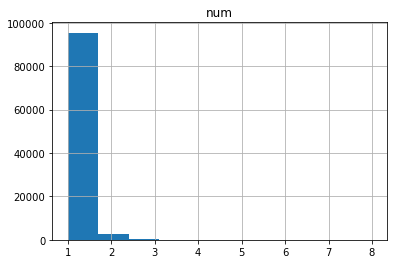

In [1044]:
# 주문당 판매 아이템 수 분포 확인
seller_orderitem.hist()

array([[<AxesSubplot:title={'center':'num'}>]], dtype=object)

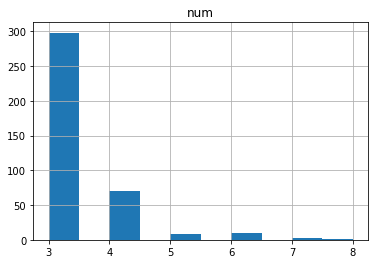

In [1045]:
# 주문당 판매 아이템 수가 2 이상인 판매 아이템 수 분포 확인
seller_orderitem[seller_orderitem['num']>2].hist()

In [1046]:
# 한 order_id에 num 2개 이상인 경우 : 약 3.3%
seller_orderitem[seller_orderitem['num']>1].shape[0] / seller_orderitem.shape[0]

0.032797518902154744

## seller_id x revenue

### 셀러별 price, freight_value, revenue 확인

In [1047]:
# revenue는 약 12 ~ 249640 BRL (약 2,400 ~ 50,130,000원) 사이에 분포
# revenue는 판매기간에 따라 다르므로 주문건별, 월별 매출로 비교할 필요가 있음
seller_revenue = item.groupby('seller_id')[['price', 'freight_value', 'revenue']].agg('sum').sort_values(by = 'revenue', ascending = False)
seller_revenue

,price,freight_value,revenue
seller_id,,,
4869f7a5dfa277a7dca6462dcf3b52b2,227406.24,19938.61,249640.70
7c67e1448b00f6e969d365cea6b010ab,143385.27,38677.08,239536.44
53243585a1d6dc2643021fd1853d8905,208199.61,11750.24,235856.68
4a3ca9315b744ce9f8e9374361493884,191178.72,33209.72,235539.96
fa1c13f2614d7b5c4749cbc52fecda94,194042.03,10042.70,204084.73
...,...,...,...
702835e4b785b67a084280efca355756,7.60,10.96,18.56
4965a7002cca77301c82d3f91b82e1a9,8.49,7.87,16.36
1fa2d3def6adfa70e58c276bb64fe5bb,6.90,9.00,15.90


<AxesSubplot:>

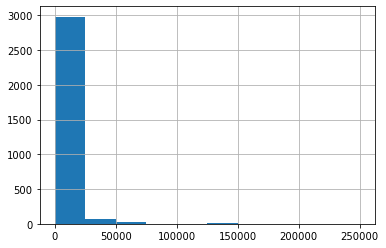

In [1048]:
# 셀러별 revenue 분포 확인
seller_revenue['revenue'].hist()

In [1049]:
# 주문당 매출은 약12 ~ 6922 BRL (약 2,400 ~ 1,390,000원) 사이에 분포
seller_item_revenue = item.groupby('seller_id')[['order_id', 'revenue']].agg({'order_id' : 'count', 'revenue' : 'sum'})
seller_item_revenue['revenue_per_order'] = seller_item_revenue['revenue'] / seller_item_revenue['order_id']
seller_item_revenue.sort_values(by = 'revenue_per_order', ascending = False)

,order_id,revenue,revenue_per_order
seller_id,,,
80ceebb4ee9b31afb6c6a916a574a1e2,1,6922.21,6922.21
ee27a8f15b1dded4d213a468ba4eb391,1,6726.66,6726.66
b37c4c02bda3161a7546a4e6d222d5b2,4,24487.60,6121.90
585175ec331ea177fa47199e39a6170a,1,3602.47,3602.47
abe021b01ba992245271b9aa422032df,2,6837.24,3418.62
...,...,...,...
702835e4b785b67a084280efca355756,1,18.56,18.56
4965a7002cca77301c82d3f91b82e1a9,1,16.36,16.36
1fa2d3def6adfa70e58c276bb64fe5bb,1,15.90,15.90


### ★item, order 데이터셋 합치기

In [1050]:
order

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [1051]:
item_order = item.merge(order, on = 'order_id', how = 'left')
item_order

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102420,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,1,343.40,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00
102421,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,1,386.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00
102422,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,1,116.85,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10 00:00:00
102423,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,1,64.71,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25 00:00:00


In [1052]:
item_order.isnull().sum()

order_id                         0   
product_id                       0   
seller_id                        0   
shipping_limit_date              0   
price                            0   
freight_value                    0   
num                              0   
revenue                          0   
customer_id                      0   
order_status                     0   
order_purchase_timestamp         0   
order_approved_at                14  
order_delivered_carrier_date     1028
order_delivered_customer_date    2230
order_estimated_delivery_date    0   
dtype: int64

In [1053]:
# 구매월 컬럼 생성
item_order['purchase_month'] = item_order['order_purchase_timestamp'].str[0:7]
item_order

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,2017-04
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,2018-01
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,2018-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,2017-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102420,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,1,343.40,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00,2018-04
102421,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,1,386.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00,2018-07
102422,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,1,116.85,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10 00:00:00,2017-10
102423,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,1,64.71,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25 00:00:00,2017-08


In [1054]:
# 셀러별 월매출은 약 10 ~ 67113 BRL (약 2,000 ~ 13,476,000원) 사이에 분포
item_order_month = item_order.groupby(['seller_id', 'purchase_month'])[['order_id', 'revenue']].agg({'order_id' : 'count', 'revenue' : 'sum'})
item_order_month.sort_values(by = 'revenue', ascending = False)

order_id   revenue
seller_id                        purchase_month                    
53243585a1d6dc2643021fd1853d8905 2017-09         83        67113.00
                                 2017-10         49        43332.35
                                 2017-08         34        35787.67
7d13fca15225358621be4086e1eb0964 2018-05         207       33484.81
7c67e1448b00f6e969d365cea6b010ab 2018-03         146       33165.34
...                                              ...            ...
9cea4682e16655f7da87f406902e989e 2017-06         1         12.89   
cf6f6bc4df3999b9c6440f124fb2f687 2017-05         1         12.22   
94b9108d4b637ba65bb4f1e53cfcf8d8 2017-09         1         11.63   
                                 2017-10         1         11.63   
0e44d110fa6a54e121cb2c095a77762f 2017-09         1         10.07   

[16441 rows x 2 columns]

<AxesSubplot:>

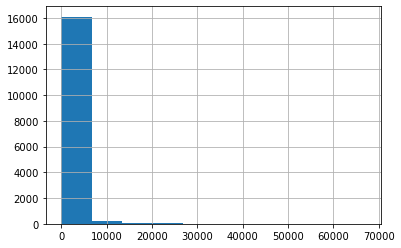

In [1055]:
# 셀러별 월 매출 분포 확인
item_order_month['revenue'].hist()

array([[<AxesSubplot:title={'center':'order_id'}>,
        <AxesSubplot:title={'center':'revenue'}>]], dtype=object)

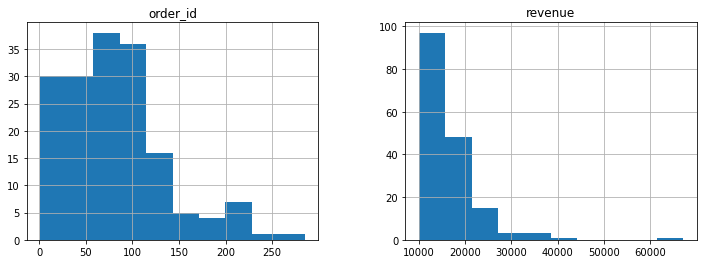

In [1056]:
# 셀러별 월 매출이 10000 이상인 경우 월 주문건수, 매출 확인
item_order_month[item_order_month['revenue']>10000].hist(figsize = (12,4))

In [1057]:
# reset_index 적용
item_order_month = item_order_month.reset_index()
item_order_month

,seller_id,purchase_month,order_id,revenue
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09,1,916.02
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,2,1832.04
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02,5,1295.40
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03,11,2124.00
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04,14,2243.22
...,...,...,...,...
16436,fffd5413c0700ac820c7069d66d98c89,2018-08,4,624.33
16437,ffff564a4f9085cd26170f4732393726,2016-10,2,146.97
16438,ffff564a4f9085cd26170f4732393726,2017-01,6,327.38
16439,ffff564a4f9085cd26170f4732393726,2017-03,11,1173.24


### 월별 주문수, 매출 기준 셀러 데이터 확인

In [1058]:
by_order_id = item_order_month.sort_values(by = 'order_id', ascending = False)
by_order_id = by_order_id.reset_index(drop = True)
by_order_id

,seller_id,purchase_month,order_id,revenue
0,1f50f920176fa81dab994f9023523100,2017-11,285,25534.97
1,955fee9216a65b617aa5c0531780ce60,2018-01,230,21668.92
2,7d13fca15225358621be4086e1eb0964,2018-05,207,33484.81
3,955fee9216a65b617aa5c0531780ce60,2018-04,206,25657.73
4,6560211a19b47992c3666cc44a7e94c0,2018-07,205,16772.21
...,...,...,...,...
16436,7bb8fac2913a6064ec412e583c6d8b4d,2018-02,1,125.52
16437,7bac63f6603d382cc8d0832eb6c100a8,2018-08,1,599.26
16438,7bac63f6603d382cc8d0832eb6c100a8,2018-01,1,418.04
16439,7bac63f6603d382cc8d0832eb6c100a8,2017-12,1,43.33


<AxesSubplot:>

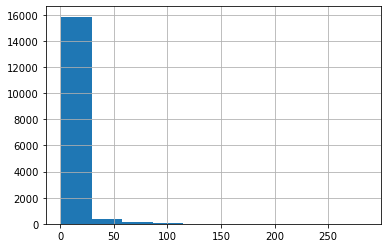

In [1059]:
by_order_id['order_id'].hist()

In [1060]:
by_revenue = item_order_month.sort_values(by = 'revenue', ascending = False)
by_revenue = by_revenue.reset_index(drop = True)
by_revenue

,seller_id,purchase_month,order_id,revenue
0,53243585a1d6dc2643021fd1853d8905,2017-09,83,67113.00
1,53243585a1d6dc2643021fd1853d8905,2017-10,49,43332.35
2,53243585a1d6dc2643021fd1853d8905,2017-08,34,35787.67
3,7d13fca15225358621be4086e1eb0964,2018-05,207,33484.81
4,7c67e1448b00f6e969d365cea6b010ab,2018-03,146,33165.34
...,...,...,...,...
16436,9cea4682e16655f7da87f406902e989e,2017-06,1,12.89
16437,cf6f6bc4df3999b9c6440f124fb2f687,2017-05,1,12.22
16438,94b9108d4b637ba65bb4f1e53cfcf8d8,2017-09,1,11.63
16439,94b9108d4b637ba65bb4f1e53cfcf8d8,2017-10,1,11.63


<AxesSubplot:>

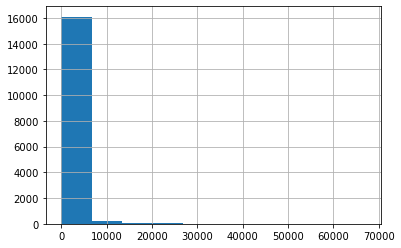

In [1061]:
by_revenue['revenue'].hist()

## product_category

### ★product, name, category 데이터셋 합치기

In [1062]:
# product_category_name 컬럼의 포르투갈어를 영어와 매칭하기 위해 product, name 데이터셋 합치기 
prod = product.merge(name, how = 'outer', on = 'product_category_name')
prod.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,perfumaria,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,perfumaria,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


In [1063]:
# product_category_name_english에 product_category_name에 있는 단어 2개가 빠져있음을 확인
prod.describe(include = 'O')

,product_id,product_category_name,product_category_name_english
count,32951,32341,32328
unique,32951,73,71
top,6da34f576ae8ae67eefc6284461cea8b,cama_mesa_banho,bed_bath_table
freq,1,3029,3029


In [1064]:
# 영문상품명 데이터에 'food_drink','food', 'drinks' 등 겹치는 카테고리가 있음을 확인
prod['product_category_name_english'].unique()

array(['perfumery', 'art', 'sports_leisure', 'baby', 'housewares',
       'musical_instruments', 'cool_stuff', 'furniture_decor',
       'home_appliances', 'toys', 'bed_bath_table',
       'construction_tools_safety', 'computers_accessories',
       'health_beauty', 'luggage_accessories', 'garden_tools',
       'office_furniture', 'auto', 'electronics', 'fashion_shoes',
       'telephony', 'stationery', 'fashion_bags_accessories', 'computers',
       'home_construction', 'watches_gifts',
       'construction_tools_construction', 'pet_shop', 'small_appliances',
       'agro_industry_and_commerce', nan, 'furniture_living_room',
       'signaling_and_security', 'air_conditioning', 'consoles_games',
       'books_general_interest', 'costruction_tools_tools',
       'fashion_underwear_beach', 'fashion_male_clothing',
       'kitchen_dining_laundry_garden_furniture',
       'industry_commerce_and_business', 'fixed_telephony',
       'construction_tools_lights', 'books_technical',
       'hom

In [1065]:
# 재분류한 영문상품명 데이터가 저장된 category 파일 불러와 prod와 합치기
category = pd.read_csv('categorizing.csv', names = ['product_category_name_english', 'new_category'])
prod_rename = prod.merge(category, on = 'product_category_name_english', how = 'outer')
prod_rename.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,new_category
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,beauty
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,beauty
2,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,beauty
3,b1eae565a61935e0011ee7682fef9dc9,perfumaria,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery,beauty
4,8da90b37f0fb171b4877c124f965b1f6,perfumaria,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery,beauty


###  ★product_category_english_name 없는 데이터 처리

In [1066]:
# 포르투갈어, 영문명 상품정보가 모두 없는 데이터는 제거
prod_rename = prod_rename[~prod_rename['product_category_name'].isnull()]
prod_rename

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,new_category
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,beauty
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,beauty
2,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,beauty
3,b1eae565a61935e0011ee7682fef9dc9,perfumaria,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery,beauty
4,8da90b37f0fb171b4877c124f965b1f6,perfumaria,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery,beauty
...,...,...,...,...,...,...,...,...,...,...,...
32946,13b25797ad1e6d6c7cd3cbeb35f8ee7a,moveis_colchao_e_estofado,44.0,348.0,1.0,18250.0,25.0,25.0,25.0,furniture_mattress_and_upholstery,furniture
32947,dc36a7859b743d8610a2bbbaea26ece9,moveis_colchao_e_estofado,29.0,2073.0,2.0,2500.0,41.0,21.0,21.0,furniture_mattress_and_upholstery,furniture
32948,107fde0930956120d1e13dd1062fbb46,moveis_colchao_e_estofado,51.0,418.0,1.0,30000.0,60.0,73.0,60.0,furniture_mattress_and_upholstery,furniture
32949,726b4e18f00255e2e63491bcba3f60b8,moveis_colchao_e_estofado,41.0,866.0,1.0,1700.0,70.0,10.0,100.0,furniture_mattress_and_upholstery,furniture


In [1067]:
# 상품명 정보가 포르투갈어로만 존재하는 데이터 확인
prod_rename.loc[prod_rename['new_category'].isnull(), 'product_category_name']

30214    pc_gamer                                     
30215    pc_gamer                                     
30216    pc_gamer                                     
30217    portateis_cozinha_e_preparadores_de_alimentos
30218    portateis_cozinha_e_preparadores_de_alimentos
30219    portateis_cozinha_e_preparadores_de_alimentos
30220    portateis_cozinha_e_preparadores_de_alimentos
30221    portateis_cozinha_e_preparadores_de_alimentos
30222    portateis_cozinha_e_preparadores_de_alimentos
30223    portateis_cozinha_e_preparadores_de_alimentos
30224    portateis_cozinha_e_preparadores_de_alimentos
30225    portateis_cozinha_e_preparadores_de_alimentos
30226    portateis_cozinha_e_preparadores_de_alimentos
Name: product_category_name, dtype: object

In [1068]:
# 재분류한 영문상품명 중 해당하는 카테고리명 할당
prod_rename.loc[(prod_rename['new_category'].isnull()) & (prod_rename['product_category_name'] == 'pc_gamer'),
           'new_category'] = 'games'
prod_rename.loc[(prod_rename['new_category'].isnull()) & (prod_rename['product_category_name'] == 'portateis_cozinha_e_preparadores_de_alimentos'),
           'new_category'] = 'home_living'

### ★prod_rename, item 데이터셋 합치기

In [1069]:
prod_order = prod_rename.merge(item, how = 'outer', on = 'product_id')
prod_order.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,new_category,order_id,seller_id,shipping_limit_date,price,freight_value,num,revenue
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,beauty,e17e4f88e31525f7deef66779844ddce,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39,1,18.30
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,beauty,048cc42e03ca8d43c729adf6962cb348,7040e82f899a04d1b434b795a43b4617,2017-11-23 21:31:31,16.90,7.78,1,24.68
2,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,beauty,5fa78e91b5cb84b6a8ccc42733f95742,7040e82f899a04d1b434b795a43b4617,2017-12-14 16:33:14,16.90,7.78,1,24.68
3,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,beauty,24b1c4d88fdb7a2dc87f8ecc7d8f47f1,fe2032dab1a61af8794248c8196565c9,2017-08-03 09:50:14,339.00,17.13,1,356.13
4,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,beauty,7b13c77c64a9a956500cbf1a9a23798d,7178f9f4dd81dcef02f62acdf8151e01,2018-05-30 10:38:35,275.00,23.48,1,298.48


In [1070]:
prod_order.describe(include = 'O')

,product_id,product_category_name,product_category_name_english,new_category,order_id,seller_id,shipping_limit_date
count,102425,100965,100943,100965,102425,102425,102425
unique,32951,73,71,21,98666,3095,93318
top,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,bed_bath_table,stationery,ca3625898fbd48669d50701aba51cd5f,6560211a19b47992c3666cc44a7e94c0,2017-11-23 20:31:15
freq,467,10160,10160,17037,8,1982,7


In [1071]:
prod_order.isnull().sum()

product_id                       0   
product_category_name            1460
product_name_lenght              1460
product_description_lenght       1460
product_photos_qty               1460
product_weight_g                 1461
product_length_cm                1461
product_height_cm                1461
product_width_cm                 1461
product_category_name_english    1482
new_category                     1460
order_id                         0   
seller_id                        0   
shipping_limit_date              0   
price                            0   
freight_value                    0   
num                              0   
revenue                          0   
dtype: int64

In [1072]:
# 포르투갈어, 영문명 상품정보가 모두 없는 데이터 제외
prod_order = prod_order[~prod_order['product_category_name'].isnull()]
prod_order

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,new_category,order_id,seller_id,shipping_limit_date,price,freight_value,num,revenue
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,beauty,e17e4f88e31525f7deef66779844ddce,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39,1,18.30
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,beauty,048cc42e03ca8d43c729adf6962cb348,7040e82f899a04d1b434b795a43b4617,2017-11-23 21:31:31,16.90,7.78,1,24.68
2,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,beauty,5fa78e91b5cb84b6a8ccc42733f95742,7040e82f899a04d1b434b795a43b4617,2017-12-14 16:33:14,16.90,7.78,1,24.68
3,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,beauty,24b1c4d88fdb7a2dc87f8ecc7d8f47f1,fe2032dab1a61af8794248c8196565c9,2017-08-03 09:50:14,339.00,17.13,1,356.13
4,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,beauty,7b13c77c64a9a956500cbf1a9a23798d,7178f9f4dd81dcef02f62acdf8151e01,2018-05-30 10:38:35,275.00,23.48,1,298.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100960,1dceebcc5f23c02ea23e16d5bedca000,cds_dvds_musicais,47.0,117.0,2.0,550.0,35.0,15.0,25.0,cds_dvds_musicals,culture,7ed69fbc79fbda50e09caa9c127026e5,4e922959ae960d389249c378d1c939f5,2018-05-02 11:54:43,65.00,52.58,1,117.58
100961,1dceebcc5f23c02ea23e16d5bedca000,cds_dvds_musicais,47.0,117.0,2.0,550.0,35.0,15.0,25.0,cds_dvds_musicals,culture,9c782cb7854e5dfa91927cfca8949eb8,4e922959ae960d389249c378d1c939f5,2017-07-19 11:35:22,45.00,16.11,1,61.11
100962,1dceebcc5f23c02ea23e16d5bedca000,cds_dvds_musicais,47.0,117.0,2.0,550.0,35.0,15.0,25.0,cds_dvds_musicals,culture,cea54c1853c864ab36cea3ef732d7191,4e922959ae960d389249c378d1c939f5,2017-11-14 11:50:17,65.00,9.94,1,74.94
100963,1dceebcc5f23c02ea23e16d5bedca000,cds_dvds_musicais,47.0,117.0,2.0,550.0,35.0,15.0,25.0,cds_dvds_musicals,culture,d4e8d3bb5e3673ed68ac154fe86de946,4e922959ae960d389249c378d1c939f5,2017-11-03 11:29:30,45.00,16.11,1,61.11


In [1073]:
# 전체 판매제품 중 가장 많이 팔린 카테고리 제품 보기
prod_order_sorted = prod_order.groupby('new_category')['product_category_name'].agg('count').sort_values(ascending = False)
popular_prod = prod_order_sorted.head(30).to_frame()
popular_prod

,product_category_name
new_category,
stationery,17037
beauty,12264
home_living,10879
electronics,10316
furniture,8647
sports,7858
home_appliances,7725
telephone,4504
auto,3991


<AxesSubplot:xlabel='new_category', ylabel='product_category_name'>

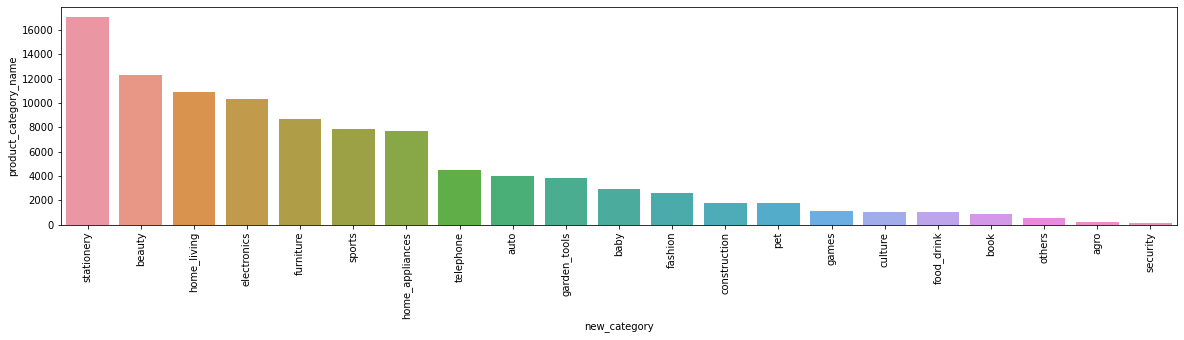

In [1074]:
plt.figure(figsize=(20, 4))
plt.xticks(rotation = 90)

sns.barplot(data = popular_prod, x = popular_prod.index, y = 'product_category_name')

In [1075]:
# 판매건수 기준 Top1 seller 판매제품 카테고리
prod_order[prod_order['seller_id'] == '6560211a19b47992c3666cc44a7e94c0'].groupby(
    'new_category')['product_category_name'].agg('count').sort_values(ascending = False)

new_category
stationery      1585
fashion         336 
electronics     42  
beauty          11  
sports          7   
construction    1   
Name: product_category_name, dtype: int64

In [1076]:
# 판매금액 기준 Top1 seller 판매제품 카테고리
prod_order[prod_order['seller_id'] == '4869f7a5dfa277a7dca6462dcf3b52b2'].groupby(
    'new_category')['product_category_name'].agg('count').sort_values(ascending = False)

new_category
stationery     1043
electronics    68  
beauty         20  
games          7   
telephone      3   
sports         1   
auto           1   
Name: product_category_name, dtype: int64

## review_score

### ★item_order, review 데이터셋 합치기

In [1077]:
# review 데이터 확인
review.head(1)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59


In [1078]:
review.describe(include = 'O')

,review_id,order_id,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,100000,100000,11715,41753,100000,100000
unique,99173,99441,4600,36921,637,99010
top,2172867fd5b1a55f98fe4608e1547b4b,c88b1d1b157a9999ce368f218a407141,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,426,230,466,4


In [1079]:
# item_order와 review 데이터셋 합치기
item_order_review = item_order.merge(review, how = 'outer', on = 'order_id')
item_order_review.head()

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1.0,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1.0,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,2017-04,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1.0,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,2018-01,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1.0,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,2018-08,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1.0,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,2017-02,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59


In [1080]:
item_order_review.describe()

,price,freight_value,num,revenue,review_score
count,103035.000000,103035.000000,103035.000000,103035.000000,103813.000000
mean,124.236486,20.100675,1.099840,154.484573,4.043232
std,188.564473,15.861700,0.456909,214.092278,1.380441
min,0.850000,0.000000,1.000000,7.280000,1.000000
25%,40.000000,13.140000,1.000000,59.920000,4.000000
50%,78.000000,16.320000,1.000000,101.340000,5.000000
75%,139.000000,21.200000,1.000000,169.985000,5.000000
max,6735.000000,409.680000,20.000000,13664.080000,5.000000


In [1081]:
item_order_review.describe(include = 'O')

,order_id,product_id,seller_id,shipping_limit_date,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,103813,103035,103035,103035,103035,103035,103035,103021,101998,100784,103035,103035,103813,12304,43905,103813,103813
unique,99441,32951,3095,93318,98666,7,98112,90174,81017,95664,450,24,99173,4600,36921,637,99010
top,5a3b1c29a49756e75f1ef513383c0c12,99a4788cb24856965c36a24e339b6058,6560211a19b47992c3666cc44a7e94c0,2017-10-24 13:06:21,be1c4e52bb71e0c54b11a26b8e8d59f2,delivered,2017-10-17 13:06:29,2017-10-18 13:06:21,2018-05-09 15:48:00,2017-10-22 14:43:54,2017-12-20 00:00:00,2017-11,b8017a9ca639f71a9a4a745985f4a729,Recomendo,Muito bom,2017-12-19 00:00:00,2018-08-24 17:07:04
freq,12,470,1988,12,12,100785,12,12,47,12,547,7841,8,439,236,478,8


### ★seller_id 없는 데이터 제거

In [1082]:
item_order_review.isnull().sum()

order_id                         0    
product_id                       778  
seller_id                        778  
shipping_limit_date              778  
price                            778  
freight_value                    778  
num                              778  
revenue                          778  
customer_id                      778  
order_status                     778  
order_purchase_timestamp         778  
order_approved_at                792  
order_delivered_carrier_date     1815 
order_delivered_customer_date    3029 
order_estimated_delivery_date    778  
purchase_month                   778  
review_id                        0    
review_score                     0    
review_comment_title             91509
review_comment_message           59908
review_creation_date             0    
review_answer_timestamp          0    
dtype: int64

In [1083]:
# item 데이터셋에는 없고 order, review 데이터셋에만 정보가 있는 아래 데이터를 살펴보면
# order_status가 delivered가 아닌 경우의 데이터가 order, review에 추가로 포함된 경우가 있는 것으로 파악됨
item[item['order_id']=='f62f01ec64c6b221f926ba560907d8f7']

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue


In [1084]:
order[order['order_id']=='f62f01ec64c6b221f926ba560907d8f7']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
64186,f62f01ec64c6b221f926ba560907d8f7,a35ef57cd99a99e77e58316ab0cc2927,unavailable,2017-02-14 20:55:49,2017-02-14 21:05:27,NaN,NaN,2017-04-03 00:00:00


In [1085]:
# 해당 건들은 item 데이터셋에 정보가 없어 seller_id, price, freight_value 등 주요 정보가 확인되지 않으므로 분석에서 제외
item_order_review = item_order_review[~item_order_review['seller_id'].isnull()]
item_order_review.head()

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1.0,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1.0,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,2017-04,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1.0,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,2018-01,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1.0,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,2018-08,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1.0,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,2017-02,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59


In [1086]:
item_order_review.describe(include = 'O')

,order_id,product_id,seller_id,shipping_limit_date,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,103035,103035,103035,103035,103035,103035,103035,103021,101998,100784,103035,103035,103035,12212,43362,103035,103035
unique,98666,32951,3095,93318,98666,7,98112,90174,81017,95664,450,24,98453,4569,36435,634,98291
top,5a3b1c29a49756e75f1ef513383c0c12,99a4788cb24856965c36a24e339b6058,6560211a19b47992c3666cc44a7e94c0,2017-10-24 13:06:21,be1c4e52bb71e0c54b11a26b8e8d59f2,delivered,2017-10-17 13:06:29,2017-10-18 13:06:21,2018-05-09 15:48:00,2017-10-22 14:43:54,2017-12-20 00:00:00,2017-11,b8017a9ca639f71a9a4a745985f4a729,Recomendo,Muito bom,2017-12-19 00:00:00,2018-08-24 17:07:04
freq,12,470,1988,12,12,100785,12,12,47,12,547,7841,8,439,236,473,8


In [1087]:
item_order_review.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
shipping_limit_date              0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
customer_id                      0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                14   
order_delivered_carrier_date     1037 
order_delivered_customer_date    2251 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             90823
review_comment_message           59673
review_creation_date             0    
review_answer_timestamp          0    
dtype: int64

### ★item_order_review, prod_order 합치기

In [1088]:
item_order_review.head(1)

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,1.0,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03


In [1089]:
prod_rename.head(1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,new_category
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,beauty


In [1090]:
df = item_order_review.merge(prod_rename, on = 'product_id', how = 'left')
df

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,new_category
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1.0,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,stationery
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1.0,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,2017-04,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop,pet
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1.0,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,2018-01,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.,2018-01-23 00:00:00,2018-01-23 16:06:31,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor,furniture
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1.0,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,2018-08,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery,beauty
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1.0,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,2017-02,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103030,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,1.0,343.40,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00,2018-04,9185f849f32d82e216a4e025e0c50f5c,5,NaN,NaN,2018-05-11 00:00:00,2018-05-14 12:53:47,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,housewares,home_appliances
103031,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,1.0,386.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00,2018-07,be803f6a93d64719fd685c1cc610918a,5,NaN,NaN,2018-07-24 00:00:00,2018-07-25 09:25:29,informatica_acessorios,31.0,232

## geolocation

### ★한 zipcode에 여러 state명 있는 경우

In [1091]:
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [1092]:
# zipcode별로 state 개수 확인
zip_code = geo[["geolocation_zip_code_prefix","geolocation_state"]].drop_duplicates().groupby(
    ["geolocation_zip_code_prefix"]).geolocation_state.count().sort_values().reset_index()
zip_code

,geolocation_zip_code_prefix,geolocation_state
0,1001,1
1,62010,1
2,62000,1
3,61979,1
4,61962,1
...,...,...
19010,79750,2
19011,2116,2
19012,80630,2
19013,4011,2


In [1093]:
# zipcode별 state가 2개인 데이터 확인
zipcode = zip_code[zip_code.geolocation_state > 1].geolocation_zip_code_prefix.tolist()
zipcode

[23056, 78557, 21550, 79750, 2116, 80630, 4011, 72915]

In [1094]:
# 위 데이터는 모두 1건씩 다른 state 정보가 잘못 들어간 경우로 파악됨
geo[geo['geolocation_zip_code_prefix']==72915].groupby(
    "geolocation_state")['geolocation_zip_code_prefix'].count().sort_values()

geolocation_state
DF    1 
GO    40
Name: geolocation_zip_code_prefix, dtype: int64

In [1095]:
# 가장 많이 등록된 state로 대체
for loc in zipcode:
    set_states = geo[geo['geolocation_zip_code_prefix']==loc].groupby(
        "geolocation_state")['geolocation_zip_code_prefix'].count().sort_values().index[-1]
    geo.loc[geo['geolocation_zip_code_prefix']==loc, "geolocation_state"] = set_states

In [1096]:
zip_code = geo[["geolocation_zip_code_prefix","geolocation_state"]].drop_duplicates().groupby(
    ["geolocation_zip_code_prefix"]).geolocation_state.count().sort_values().reset_index()
zip_code

,geolocation_zip_code_prefix,geolocation_state
0,1001,1
1,62014,1
2,62011,1
3,62010,1
4,62000,1
...,...,...
19010,19908,1
19011,19907,1
19012,19906,1
19013,19904,1


In [1097]:
seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [1098]:
# zipcode별 state가 2개 이상인 데이터 확인
zipcode_seller = seller[["seller_zip_code_prefix","seller_state"]].drop_duplicates().groupby(
    ["seller_zip_code_prefix"])['seller_state'].count().sort_values().reset_index()
zipcode_seller

,seller_zip_code_prefix,seller_state
0,1001,1
1,31110,1
2,31050,1
3,31035,1
4,31030,1
...,...,...
2241,95076,2
2242,22783,2
2243,81020,2
2244,81560,2


In [1099]:
# 위 데이터는 각각 다른 state명이 1건씩 들어가 있어, 어떤 정보가 정확한지 판단하기 어려움
# geo, seller 데이터셋 통합시에는 zip_code 기준으로 진행하고, state명은 geo 데이터셋의 정보 기준으로 진행키로 함
seller[seller['seller_zip_code_prefix']==85960].groupby(
    "seller_state")['seller_zip_code_prefix'].count().sort_values()

seller_state
PA    1
PR    1
SP    1
Name: seller_zip_code_prefix, dtype: int64

### ★geo, seller, df 데이터셋 합치기

In [1100]:
# 불필요 컬럼 삭제
geo = geo.drop(['geolocation_lat', 'geolocation_lng', 'geolocation_city'], axis = 1)
geo.head()

,geolocation_zip_code_prefix,geolocation_state
0,1037,SP
1,1046,SP
2,1046,SP
3,1041,SP
4,1035,SP


In [1101]:
seller

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [1102]:
# seller 데이터셋의 zipcode 중 geo에 없는 경우 확인
seller_zipcode_list = set(seller['seller_zip_code_prefix']) - set(geo['geolocation_zip_code_prefix'])
seller_zipcode_list

{2285, 7412, 37708, 71551, 72580, 82040, 91901}

In [1103]:
# 해당 데이터만 따로 저장
seller_unique_zipcode = seller.loc[seller['seller_zip_code_prefix'].isin(seller_zipcode_list),
                                   ['seller_zip_code_prefix', 'seller_state']].rename(columns = {
    'seller_zip_code_prefix' : 'geolocation_zip_code_prefix', 'seller_state' : 'geolocation_state'}).reset_index(drop = True)
seller_unique_zipcode

,geolocation_zip_code_prefix,geolocation_state
0,82040,PR
1,91901,RS
2,72580,DF
3,2285,SP
4,7412,SP
5,71551,DF
6,37708,MG


In [1104]:
geo_full = pd.concat([geo, seller_unique_zipcode], axis = 0)
geo_full

,geolocation_zip_code_prefix,geolocation_state
0,1037,SP
1,1046,SP
2,1046,SP
3,1041,SP
4,1035,SP
...,...,...
2,72580,DF
3,2285,SP
4,7412,SP
5,71551,DF


In [1105]:
seller_geo = seller.merge(geo_full, left_on = 'seller_zip_code_prefix', right_on = 'geolocation_zip_code_prefix', how = 'left')
seller_geo

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023,SP
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023,SP
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023,SP
3,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023,SP
4,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023,SP
...,...,...,...,...,...,...
435089,9e25199f6ef7e7c347120ff175652c3b,12051,taubate,SP,12051,SP
435090,9e25199f6ef7e7c347120ff175652c3b,12051,taubate,SP,12051,SP
435091,9e25199f6ef7e7c347120ff175652c3b,12051,taubate,SP,12051,SP
435092,9e25199f6ef7e7c347120ff175652c3b,12051,taubate,SP,12051,SP


In [1106]:
seller_geo = seller_geo.drop(['seller_zip_code_prefix', 'geolocation_zip_code_prefix', 'seller_city', 'seller_state'], axis = 1).drop_duplicates()
seller_geo

,seller_id,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,SP
80,d1b65fc7debc3361ea86b5f14c68d2e2,SP
183,ce3ad9de960102d0677a81f5d0bb7b2d,RJ
570,c0f3eea2e14555b6faeea3dd58c1b1c3,SP
745,51a04a8a6bdcb23deccc82b0b80742cf,SP
...,...,...
434713,98dddbc4601dd4443ca174359b237166,PR
434781,f8201cab383e484733266d1906e2fdfa,SC
434860,74871d19219c7d518d0090283e03c137,SP
434928,e603cf3fec55f8697c9059638d6c8eb5,RS


In [1107]:
# df 데이터셋과 최종 합치기
df = df.merge(seller_geo, on = 'seller_id', how = 'left')
df

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,new_category,geolocation_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1.0,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,stationery,RJ
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1.0,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,2017-04,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop,pet,SP
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1.0,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,2018-01,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.,2018-01-23 00:00:00,2018-01-23 16:06:31,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor,furniture,MG
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1.0,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,2018-08,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery,beauty,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1.0,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,2017-02,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools,garden_tools,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103030,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,1.0,343.40,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00,2018-04,9185f849f32d82e216a4e025e0c50f5c,5,NaN,NaN,2018-05-11 00:00:00,2018-05-14 12:53:47,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,housewares,home_appliances,SC
103031,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,1.0,386.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00,2018-07,be803f6a93d64719fd685c1cc610918a,5,NaN,NaN,2018-07-24 00:00:00,2018-07-25 

### 데이터 최종 정리

In [1108]:
# 데이터 통합 과정에서 product_category_name이 null인 데이터 다시 발생
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
shipping_limit_date              0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
customer_id                      0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                14   
order_delivered_carrier_date     1037 
order_delivered_customer_date    2251 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             90823
review_comment_message           59673
review_creation_date             0    
review_answer_timestamp          0    
product_category_name            1469 
product_name_lenght              1469 
product_description_lenght       1469 
product_photos_qty       

In [1109]:
# 해당 데이터 제거
df = df[~df['product_category_name'].isnull()]
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
shipping_limit_date              0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
customer_id                      0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                13   
order_delivered_carrier_date     1003 
order_delivered_customer_date    2191 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             89424
review_comment_message           58850
review_creation_date             0    
review_answer_timestamp          0    
product_category_name            0    
product_name_lenght              0    
product_description_lenght       0    
product_photos_qty       

In [1110]:
# 구매월별 매출건수 확인
df.groupby('purchase_month')['order_id'].count()

purchase_month
2016-09    4   
2016-10    328 
2016-12    1   
2017-01    824 
2017-02    1751
2017-03    2691
2017-04    2409
2017-05    3758
2017-06    3309
2017-07    4120
2017-08    4443
2017-09    4358
2017-10    4748
2017-11    7726
2017-12    5713
2018-01    7379
2018-02    6855
2018-03    7331
2018-04    7169
2018-05    7089
2018-06    6388
2018-07    6471
2018-08    6700
2018-09    1   
Name: order_id, dtype: int64

In [1111]:
# 2016년 9월~12월과 2018년 9월 주문건수는 다른 월에 비해 현저히 낮음
# 서비스 테스트 등 다른 이슈가 있었던 기간이었을 가능성이 있다고 보고 해당 월은 분석에서 제외
df = df[~df['purchase_month'].isin(['2016-09', '2016-10', '2016-12', '2018-09'])]
df.groupby('purchase_month')['order_id'].count()

purchase_month
2017-01    824 
2017-02    1751
2017-03    2691
2017-04    2409
2017-05    3758
2017-06    3309
2017-07    4120
2017-08    4443
2017-09    4358
2017-10    4748
2017-11    7726
2017-12    5713
2018-01    7379
2018-02    6855
2018-03    7331
2018-04    7169
2018-05    7089
2018-06    6388
2018-07    6471
2018-08    6700
Name: order_id, dtype: int64

### review_score 분포 확인

<AxesSubplot:>

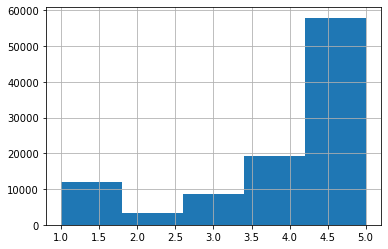

In [1112]:
# 전체 review_score
df['review_score'].hist(bins = 5)

In [1113]:
# 월별 review_score 평균
df_month = df.groupby('purchase_month')['review_score'].agg('mean').reset_index()
df_month

,purchase_month,review_score
0,2017-01,4.080097
1,2017-02,4.055397
2,2017-03,4.083984
3,2017-04,4.026982
4,2017-05,4.141565
5,2017-06,4.135388
6,2017-07,4.160680
7,2017-08,4.229124
8,2017-09,4.171409
9,2017-10,4.093513


<AxesSubplot:xlabel='purchase_month', ylabel='review_score'>

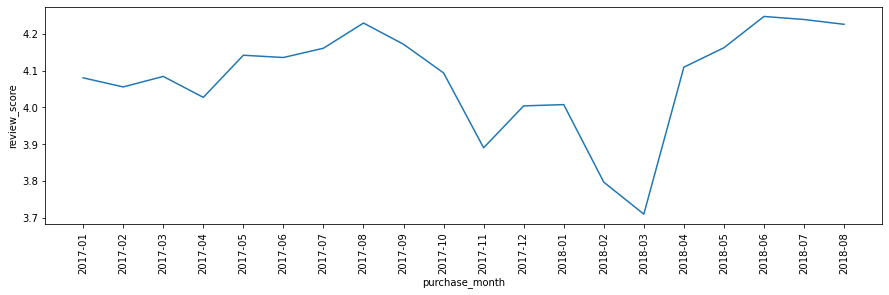

In [1114]:
# 2017년 11월 ~ 2018년 3월에 review_score 평균이 상대적으로 낮았음을 확인
plt.figure(figsize = (15, 4))
plt.xticks(rotation = 90)
sns.lineplot(data = df_month, x = 'purchase_month', y = 'review_score')

In [1115]:
# 제품 카테고리별 review_score 평균
df_category = df.groupby('new_category')['review_score'].agg('mean').sort_values(ascending = False).reset_index()
df_category

,new_category,review_score
0,book,4.410317
1,food_drink,4.246276
2,pet,4.192090
3,beauty,4.166884
4,sports,4.141591
5,culture,4.131478
6,stationery,4.131200
7,home_appliances,4.119219
8,garden_tools,4.111285
9,fashion,4.103073


<AxesSubplot:xlabel='new_category', ylabel='review_score'>

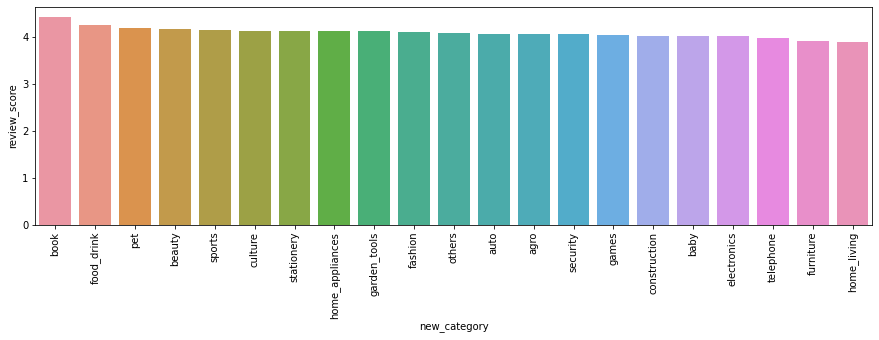

In [1116]:
# 제품 카테고리별 review_score 평균에 일부 차이가 있음을 확인
plt.figure(figsize = (15, 4))
plt.xticks(rotation = 90)
sns.barplot(data = df_category, x = 'new_category', y = 'review_score')

In [1117]:
# 셀러별 review_score 평균
df_random_seller = df.groupby('seller_id')['review_score'].agg('mean').sort_values(ascending = False).reset_index().sample(20)
df_random_index = df_random_seller['seller_id'].tolist()

In [1118]:
# 셀러 20명을 랜덤 추출하여 review_score 분포 확인
df_random = df.loc[df['seller_id'].isin(df_random_index), ['seller_id', 'review_score']].reset_index()
df_random

,index,seller_id,review_score
0,106,f457c46070d02cadd8a68551231220dd,2
1,612,dc64d75cc406bb0697be983831430e60,5
2,1301,f457c46070d02cadd8a68551231220dd,5
3,1406,f457c46070d02cadd8a68551231220dd,4
4,1973,d06d019f72a04e5497a0b64190af170c,5
...,...,...,...
457,101218,f457c46070d02cadd8a68551231220dd,5
458,101431,977f9f63dd360c2a32ece2f93ad6d306,3
459,101863,845e8036c3f7bf62099352f5ed910240,2
460,101952,d06d019f72a04e5497a0b64190af170c,5


<AxesSubplot:xlabel='seller_id', ylabel='review_score'>

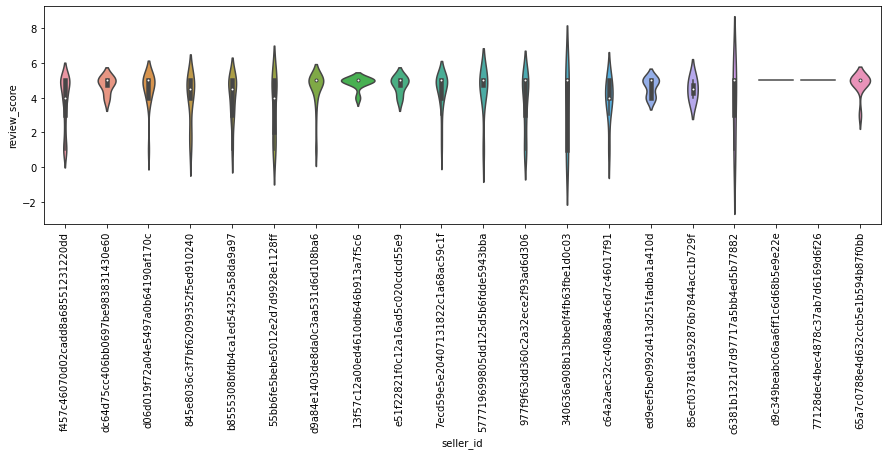

In [1119]:
# 셀러마다 판매건수가 달라 review_score 분포도 다양한 형태로 나타남
plt.figure(figsize = (15, 4))
plt.xticks(rotation = 90)
sns.violinplot(data = df_random, x = 'seller_id', y = 'review_score')

In [1120]:
# order_status별 review_score 평균
df_status = df.groupby('order_status')['review_score'].agg('mean').sort_values(ascending = False).reset_index()
df_status

,order_status,review_score
0,delivered,4.114255
1,approved,2.500000
2,shipped,2.008152
3,invoiced,1.670000
4,canceled,1.596372
5,processing,1.281787


<AxesSubplot:xlabel='order_status', ylabel='review_score'>

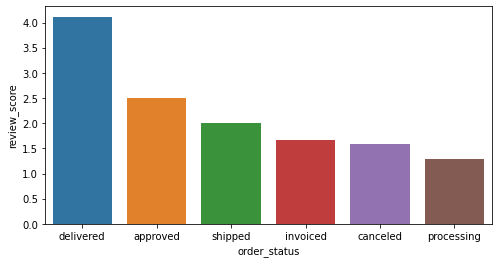

In [1121]:
# delivered가 아닌 나머지 status의 review_score 평균은 낮음

plt.figure(figsize = (8, 4))
sns.barplot(data = df_status, x = 'order_status', y = 'review_score')

In [1122]:
# 판매건수는 São Paulo(SP)가 압도적으로 많음
df_city = df.groupby('geolocation_state')['review_score'].agg(['mean','count']).sort_values(by = 'count', ascending = False)
df_city

,mean,count
geolocation_state,,
SP,4.037406,71432
MG,4.144105,8126
PR,4.107928,7959
RJ,4.128844,4455
SC,4.105534,3885
RS,4.259315,1986
DF,4.050122,818
BA,4.095486,576
GO,4.256356,472


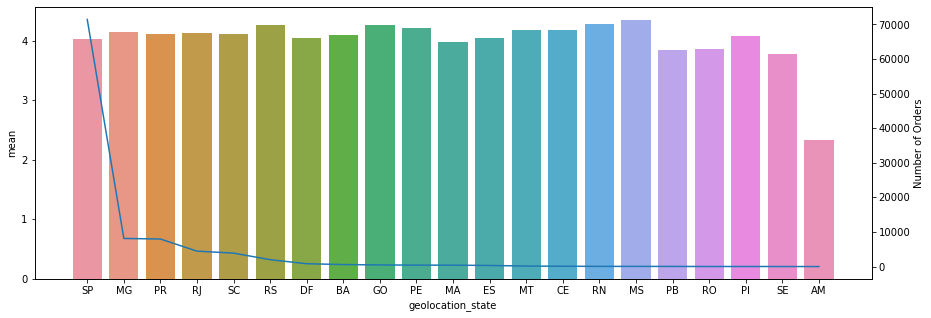

In [1123]:
# state별로 평균 review_score의 평균이 다름을 확인할 수 있음
# 셀러가 Amazonas(AM) 주에 있는 경우 review_score 평균이 가장 낮음

fig, ax1 = plt.subplots(figsize = (15,5))
ax1.set_xlabel('State')
ax1.set_ylabel('Review Score')
ax1 = sns.barplot(x = df_city.index, y = 'mean', data = df_city)
ax1.tick_params(axis = 'y')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of Orders')
ax2 = sns.lineplot(x = df_city.index, y = 'count', data = df_city, sort=False)
ax2.tick_params(axis = 'y')

plt.show()

# 컬럼 삭제 및 추가

## 분석대상 재설정
### ★한 order_id에 여러 seller_id, product_id 있는 경우

In [1124]:
check_orderitem = df.groupby('order_id')['seller_id', 'product_id'].agg('count').reset_index()
check_orderitem = check_orderitem[check_orderitem['seller_id']>1]
check_orderitem

,order_id,seller_id,product_id
73,002f98c0f7efd42638ed6100ca699b42,2,2
82,00337fe25a3780b3424d9ad7c5a4b35e,2,2
85,0035246a40f520710769010f752e7507,2,2
130,005d9a5423d47281ac463a968b3936fb,2,2
193,00946f674d880be1f188abc10ad7cf46,2,2
...,...,...,...
96855,ffb18bf111fa70edf316eb0390427986,2,2
96863,ffb8f7de8940249a3221252818937ecb,3,3
96864,ffb9a9cd00c74c11c24aa30b3d78e03b,3,3
96875,ffc16cecff8dc037f60458f28d1c1ba5,2,2


In [1125]:
check_orderitem_index = check_orderitem['order_id'].tolist()
check_orderitem_index

['002f98c0f7efd42638ed6100ca699b42',
 '00337fe25a3780b3424d9ad7c5a4b35e',
 '0035246a40f520710769010f752e7507',
 '005d9a5423d47281ac463a968b3936fb',
 '00946f674d880be1f188abc10ad7cf46',
 '0097f0545a302aafa32782f1734ff71c',
 '00bcee890eba57a9767c7b5ca12d3a1b',
 '01144cadcf64b6427f0a6580a3033220',
 '01235dc626dcf13283207ba7f36a959a',
 '012a238ab54294a3b365812ccc82b135',
 '013056cfe49763c6f66bda03396c5ee3',
 '0132451f29a10b66a5cf1bacc85f9afe',
 '013a98b3a668bcef05b98898177f6923',
 '014405982914c2cde2796ddcf0b8703d',
 '015183dcb37f19e0456905fa5aac0b69',
 '017499de14d22ef9e9a83ca54727480e',
 '0176a6846bcb3b0d3aa3116a9a768597',
 '0179a3003c894f1dd3b1ddda5d1f8a12',
 '017dcb6892d4469a13dee34f241f8c4e',
 '018bb1508d9156b81990407b91fb35a8',
 '01a4ec962d7589584c11650ca20d728b',
 '01b1a7fdae9ad1837d6ab861705a1fa5',
 '01cce1175ac3c4a450e3a0f856d02734',
 '02355020fd0a40a0d56df9f6ff060413',
 '023669233121f0fb7899e5be2b22885f',
 '023af4b88d12c9f3f56bcb55da0450c5',
 '024554aeb0da84476f1c31a711e0990c',
 

In [1126]:
df[df['order_id']=='0245631f7bd55dbee7c6b441629bba94']

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,new_category,geolocation_state
887,0245631f7bd55dbee7c6b441629bba94,2b10e945dae5434075c8bb2be0d17325,da8622b14eb17ae2831f4ac5b9dab84a,2017-10-11 18:45:20,279.9,30.84,1.0,310.74,4d82e79f5404e8c3f059ab099fbe5dda,delivered,2017-10-05 18:26:36,2017-10-05 18:45:20,2017-10-06 19:48:55,2017-10-13 21:37:42,2017-11-01 00:00:00,2017-10,2cb679cfffd69784ae97b7f48293f6bd,2,NaN,"Essa cortina não veio com as demais:Cortina Voil Branca 8,00x2,80 Forro Microfibra Ilhós Cromado Branco",2017-10-14 00:00:00,2017-10-15 20:03:59,cama_mesa_banho,60.0,233.0,1.0,2950.0,46.0,8.0,38.0,bed_bath_table,home_living,SP
888,0245631f7bd55dbee7c6b441629bba94,372645c7439f9661fbbacfd129aa92ec,da8622b14eb17ae2831f4ac5b9dab84a,2017-10-11 18:45:20,119.9,13.13,1.0,133.03,4d82e79f5404e8c3f059ab099fbe5dda,delivered,2017-10-05 18:26:36,2017-10-05 18:45:20,2017-10-06 19:48:55,2017-10-13 21:37:42,2017-11-01 00:00:00,2017-10,2cb679cfffd69784ae97b7f48293f6bd,2,NaN,"Essa cortina não veio com as demais:Cortina Voil Branca 8,00x2,80 Forro Microfibra Ilhós Cromado Branco",2017-10-14 00:00:00,2017-10-15 20:03:59,cama_mesa_banho,60.0,236.0,1.0,1500.0,34.0,7.0,32.0,bed_bath_table,home_living,SP
889,0245631f7bd55dbee7c6b441629bba94,525947dbe3304ac32bf51602f9557c12,da8622b14eb17ae2831f4ac5b9dab84a,2017-10-11 18:45:20,119.9,12.33,1.0,132.23,4d82e79f5404e8c3f059ab099fbe5dda,delivered,2017-10-05 18:26:36,2017-10-05 18:45:20,2017-10-06 19:48:55,2017-10-13 21:37:42,2017-11-01 00:00:00,2017-10,2cb679cfffd69784ae97b7f48293f6bd,2,NaN,"Essa cortina não veio com as demais:Cortina Voil Branca 8,00x2,80 Forro Microfibra Ilhós Cromado Branco",2017-10-14 00:00:00,2017-10-15 20:03:59,cama_mesa_banho,60.0,236.0,1.0,2600.0,34.0,7.0,32.0,bed_bath_table,home_living,SP
890,0245631f7bd55dbee7c6b441629bba94,eb53f94fdc60278efcef123bb275658a,da8622b14eb17ae2831f4ac5b9dab84a,2017-10-11 18:45:20,329.9,33.82,1.0,363.72,4d82e79f5404e8c3f059ab099fbe5dda,delivered,2017-10-05 18:26:36,2017-10-05 18:45:20,2017-10-06 19:48:55,2017-10-13 21:37:42,2017-11-01 00:00:00,2017-10,2cb679cfffd69784ae97b7f48293f6bd,2,NaN,"Essa cortina não veio com as demais:Cortina Voil Branca 8,00x2,80 Forro Microfibra Ilhós Cromado Branco",2017-10-14 00:00:00,2017-10-15 20:03:59,cama_mesa_banho,60.0,270.0,1.0,3400.0,39.0,13.0,46.0,bed_bath_table,home_living,SP


In [1127]:
# 해당 데이터는 어떤 셀러, 어떤 제품때문에 해당 review_score를 받았는지 구분이 불가하므로 제거
df = df[~df['order_id'].isin(check_orderitem_index)]
df

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,new_category,geolocation_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1.0,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,stationery,RJ
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1.0,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,2017-04,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop,pet,SP
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1.0,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,2018-01,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.,2018-01-23 00:00:00,2018-01-23 16:06:31,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor,furniture,MG
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1.0,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,2018-08,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery,beauty,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1.0,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,2017-02,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools,garden_tools,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103030,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,1.0,343.40,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00,2018-04,9185f849f32d82e216a4e025e0c50f5c,5,NaN,NaN,2018-05-11 00:00:00,2018-05-14 12:53:47,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,housewares,home_appliances,SC
103031,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,1.0,386.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00,2018-07,be803f6a93d64719fd685c1cc610918a,5,NaN,NaN,2018-07-24 00:00:00,2018-07-25 

### ★한 order_id에 여러 review_id가 있는 경우

In [1128]:
# 여러 review가 발생한 원인을 정확하게 파악할 수 없으므로 해당 데이터는 모두 삭제
# (실제로 고객의 만족도가 달라진 경우일 수도 있고, 리뷰점수 조작인 경우도 있을 수 있음)
check_review = df.groupby('order_id')['review_id'].agg('count').reset_index()
check_review

,order_id,review_id
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
93296,fffc94f6ce00a00581880bf54a75a037,1
93297,fffcd46ef2263f404302a634eb57f7eb,1
93298,fffce4705a9662cd70adb13d4a31832d,1
93299,fffe18544ffabc95dfada21779c9644f,1


In [1129]:
# 한 order_id에 여러 seller_id, product_id 있는 경우 제거하고 나니 review_id가 여러건인 데이터는 없어짐?
check_review[check_review['review_id'] > 1]

,order_id,review_id


### order_delivered_customer_date 없는 경우

In [1130]:
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
shipping_limit_date              0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
customer_id                      0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                13   
order_delivered_carrier_date     929  
order_delivered_customer_date    2043 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             82267
review_comment_message           55056
review_creation_date             0    
review_answer_timestamp          0    
product_category_name            0    
product_name_lenght              0    
product_description_lenght       0    
product_photos_qty       

In [1131]:
# 'order_delivered_customer_date'가 null인 경우의 review_comment 확인 : 대부분이 제품을 제대로 받지 못한 경우
temp = df[df['order_delivered_customer_date'].isnull()]
temp.loc[~temp['review_comment_message'].isnull(), 'review_comment_message']

72        Minha mercadoria não chegou e ninguém entrou em contato para resolver nada...                                                        
240       comprometimento com o cliente                                                                                                        
250       Não recebi o produto ainda                                                                                                           
383       O produto não veio                                                                                                                   
495       Recebi um comunicado que não teria o produto no estoque da loja, foi feito o cancelamento e estou aguardando o estorno do valor pago 
                                                                          ...                                                                  
102560    Estou aguardando o produto até agora!\r\nEspero que a loja lannister tome as devidas providências.                            

In [1132]:
# 'order_delivered_carrier_date'가 null인 경우의 review_comment 확인 : 대부분이 제품을 제대로 받지 못한 경우
temp = df[df['order_delivered_carrier_date'].isnull()]
temp.loc[~temp['review_comment_message'].isnull(), 'review_comment_message']

250       Não recebi o produto ainda                                                                                                                                               
383       O produto não veio                                                                                                                                                       
495       Recebi um comunicado que não teria o produto no estoque da loja, foi feito o cancelamento e estou aguardando o estorno do valor pago                                     
506       PRODUTO NÃO RECEBIDO                                                                                                                                                     
533       Comprei duas banquetas brancas no site pra ser entregue até 13/03 e até agora não recebi bem minha casa.Aguardo providências ou vou procurar meus direitos d consumidora.
                                                                                            ...     

Text(0.5, 1.0, 'DF')

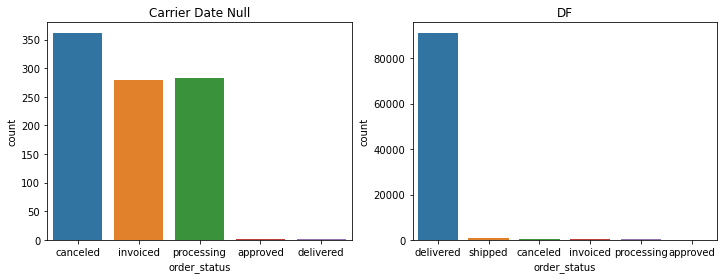

In [1133]:
# 배송일자가 없는 데이터와 전체 데이터 order_status 건수 비교
f,ax = plt.subplots(1, 2, figsize = (12,4))

sns.countplot(data = temp, x = 'order_status', ax = ax[0])
ax[0].set_title('Carrier Date Null')

sns.countplot(data = df, x = 'order_status', ax = ax[1])
ax[1].set_title('DF')

Text(0.5, 1.0, 'DF')

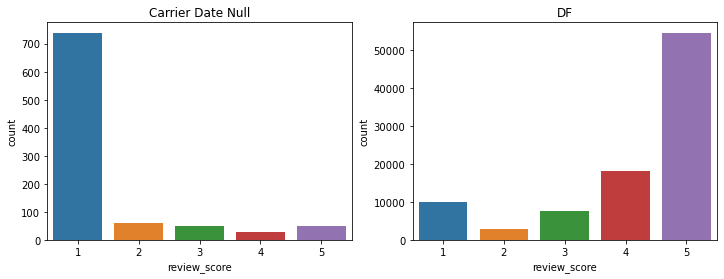

In [1134]:
# 배송일자가 없는 데이터와 전체 데이터 review_score 건수 비교
f,ax = plt.subplots(1, 2, figsize = (12,4))

sns.countplot(data = temp, x = 'review_score', ax = ax[0])
ax[0].set_title('Carrier Date Null')

sns.countplot(data = df, x = 'review_score', ax = ax[1])
ax[1].set_title('DF')

# 배송일자가 없는 데이터는 취소되었거나 배송 진행중인 데이터가 대부분으로, review_score가 낮은 것으로 확인됨
# 해당 데이터를 제거하는 것은 부적절할 것으로 판단되며, 추후 배송소요일 등의 날짜 계산시 별도의 처리를 하기로 함

## ★불필요 컬럼 삭제

In [1135]:
df.head(1)

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,revenue,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,new_category,geolocation_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,1.0,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,stationery,RJ


In [1136]:
df = df.drop(['shipping_limit_date', 'customer_id', 'review_answer_timestamp', 'product_category_name', 'product_category_name_english',
             'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm',
              'product_height_cm', 'product_width_cm'], axis = 1)
df.head(1)

,order_id,product_id,seller_id,price,freight_value,num,revenue,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,new_category,geolocation_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,1.0,72.19,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,stationery,RJ


In [1137]:
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                13   
order_delivered_carrier_date     929  
order_delivered_customer_date    2043 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             82267
review_comment_message           55056
review_creation_date             0    
new_category                     0    
geolocation_state                0    
dtype: int64

In [1138]:
df.describe()

,price,freight_value,num,revenue,review_score
count,93301.000000,93301.000000,93301.000000,93301.000000,93301.000000
mean,127.461164,20.297452,1.099056,158.002670,4.119120
std,193.362795,15.957401,0.455813,219.622159,1.319522
min,0.850000,0.000000,1.000000,9.590000,1.000000
25%,42.440000,13.370000,1.000000,61.010000,4.000000
50%,79.900000,16.430000,1.000000,103.040000,5.000000
75%,139.990000,21.290000,1.000000,173.670000,5.000000
max,6735.000000,409.680000,20.000000,13664.080000,5.000000


In [1139]:
df.describe(include = 'O')

,order_id,product_id,seller_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_comment_title,review_comment_message,review_creation_date,new_category,geolocation_state
count,93301,93301,93301,93301,93301,93288,92372,91258,93301,93301,93301,11034,38245,93301,93301,93301
unique,93301,30159,2980,6,92916,85528,76843,90529,420,20,93041,4307,33896,583,21,21
top,536a79f3bcb2ac2163cd5c46695fb573,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,delivered,2018-02-19 15:37:47,2018-02-27 04:31:10,2018-05-09 15:48:00,2017-12-02 00:26:45,2018-05-29 00:00:00,2017-11,70509c441d994fa03d6c1457930c9024,Recomendo,Muito bom,2017-12-19 00:00:00,stationery,SP
freq,1,429,1711,91265,3,9,47,3,490,7027,3,407,217,435,16046,65484


## 날짜관련 컬럼

### dtype 수정

In [1140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93301 entries, 0 to 103034
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       93301 non-null  object 
 1   product_id                     93301 non-null  object 
 2   seller_id                      93301 non-null  object 
 3   price                          93301 non-null  float64
 4   freight_value                  93301 non-null  float64
 5   num                            93301 non-null  float64
 6   revenue                        93301 non-null  float64
 7   order_status                   93301 non-null  object 
 8   order_purchase_timestamp       93301 non-null  object 
 9   order_approved_at              93288 non-null  object 
 10  order_delivered_carrier_date   92372 non-null  object 
 11  order_delivered_customer_date  91258 non-null  object 
 12  order_estimated_delivery_date  93301 non-null

In [1141]:
# 날짜 관련 컬럼 datetime 타입으로 변환
df.loc[:, 'order_purchase_timestamp':'order_estimated_delivery_date'] = df.loc[:, 'order_purchase_timestamp':'order_estimated_delivery_date'].apply(pd.to_datetime)
df.loc[:, 'review_creation_date'] = df.loc[:, 'review_creation_date'].apply(pd.to_datetime)

In [1142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93301 entries, 0 to 103034
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93301 non-null  object        
 1   product_id                     93301 non-null  object        
 2   seller_id                      93301 non-null  object        
 3   price                          93301 non-null  float64       
 4   freight_value                  93301 non-null  float64       
 5   num                            93301 non-null  float64       
 6   revenue                        93301 non-null  float64       
 7   order_status                   93301 non-null  object        
 8   order_purchase_timestamp       93301 non-null  datetime64[ns]
 9   order_approved_at              93288 non-null  datetime64[ns]
 10  order_delivered_carrier_date   92372 non-null  datetime64[ns]
 11  order_delivere

### ★ 'delay', 'avg_delivery', 'preparation' 컬럼 생성

- delay : 배달 지연일수 (완료일 - 예정일)
- avg_delivery : 평균 배송일수 (완료일 - 주문일)
- preparation : 제품 준비기간 (발송일 - 주문일)

In [1143]:
df['delay'] =  (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df['avg_delivery'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['preparation'] = (df['order_delivered_carrier_date'] - df['order_purchase_timestamp']).dt.days

In [1144]:
df.head()

,order_id,product_id,seller_id,price,freight_value,num,revenue,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,new_category,geolocation_state,delay,avg_delivery,preparation
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,1.0,72.19,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21,stationery,RJ,-9.0,7.0,6.0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,1.0,259.83,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13,pet,SP,-3.0,16.0,8.0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,1.0,216.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.,2018-01-23,furniture,MG,-14.0,7.0,1.0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,1.0,25.78,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15,beauty,SP,-6.0,6.0,2.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,1.0,218.04,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02,garden_tools,PR,-16.0,25.0,11.0


<AxesSubplot:xlabel='preparation', ylabel='Density'>

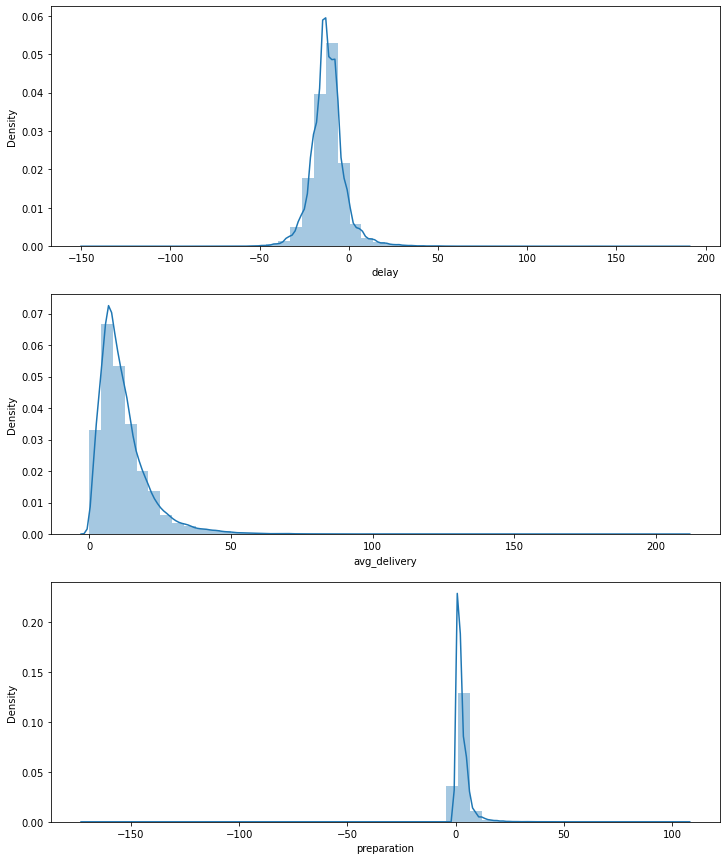

In [1145]:
# 새로 생성한 3개 변수 분포 distplot으로 확인
f,ax = plt.subplots(3, 1, figsize = (12,15))

sns.distplot(df['delay'], ax=ax[0])
sns.distplot(df['avg_delivery'], ax=ax[1])
sns.distplot(df['preparation'], ax=ax[2])

In [1146]:
# 배달 지연일수 (완료일 - 예정일)
# 147일 일찍 도착 ~ 188일 지연 사이에 분포, 평균적으로 11.7일 일찍 도착함
df['delay'].min(), df['delay'].max(), round(df['delay'].mean(),1)

(-147.0, 188.0, -11.7)

In [1147]:
# 100일+ 빨리 도착한 특이 데이터 확인
# 예정일이 너무 늦은 시점으로 잡혀있었던 경우로 확인됨
df[df['delay'] < -100]

,order_id,product_id,seller_id,price,freight_value,num,revenue,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,new_category,geolocation_state,delay,avg_delivery,preparation
2444,0607f0efea4b566f1eb8f7d3c2397320,952ef4ed720bf5d77f42712da90f2f49,903037660cf848a717166eb7a06d616e,62.99,10.09,2.0,146.16,delivered,2018-03-06 09:47:07,2018-03-06 09:55:47,2018-03-07 21:33:39,2018-03-09 23:36:47,2018-08-03,2018-03,910f7f863978cf42c85c79c9aaefe353,5,NaN,NaN,2018-03-10,furniture,SP,-147.0,3.0,1.0
26037,40dc2ba6f322a17626aac6244332828c,38841dec90eddf2f43cdfabc48b3831a,1354d51653f645349064725ed204e85e,40.00,14.10,1.0,54.10,delivered,2017-10-05 21:39:05,2017-10-05 21:49:21,2017-10-09 12:13:58,2017-10-13 13:49:07,2018-01-30,2017-10,d926e41f5d8da4624f4850e60d7fc8fc,5,NaN,NaN,2017-10-14,culture,SP,-109.0,7.0,3.0
78356,c2bb89b5c1dd978d507284be78a04cb2,87b92e06b320e803d334ac23966c80b1,7a241947449cc45dbfda4f9d0798d9d0,99.99,61.44,2.0,322.86,delivered,2017-05-23 22:28:36,2017-05-24 22:35:08,2017-05-29 02:03:28,2017-06-09 13:35:54,2017-10-11,2017-05,6afeab17c60f9f9402bbf93abdce63e3,5,NaN,NaN,2017-06-10,home_appliances,MG,-124.0,16.0,5.0
80172,c72727d29cde4cf870d569bf65edabfd,ee2f96cb63d491d963a67285f048775a,fce62094ffe6a4009188ec44e681dfdd,25.90,26.09,1.0,51.99,delivered,2017-02-07 18:01:15,2017-02-09 02:50:07,2017-02-10 05:32:55,2017-02-14 14:27:45,2017-07-04,2017-02,2e33927523fc955215bff05187cea86b,5,NaN,NaN,2017-02-15,others,SP,-140.0,6.0,2.0
96158,eec7f369423b033e549c02f3c5381205,29dcc20b00ccb0dd2136eb2f4c5f3847,903037660cf848a717166eb7a06d616e,252.99,19.02,1.0,272.01,delivered,2018-02-06 20:44:56,2018-02-08 10:10:31,2018-02-15 20:42:12,2018-02-27 16:35:43,2018-07-12,2018-02,308aa99a70d28ba75e803ec8caf49088,3,NaN,Meu produto chegou quebrado não sei como proceder pois acredito que tenha sido quebrado durante o transporte dos correios,2018-02-28,furniture,SP,-135.0,20.0,8.0


In [1148]:
# 평균 배송일수 (완료일 - 주문일)
# 0 ~ 209일 사이에 분포, 평균 12.1일 소요
df['avg_delivery'].min(), df['avg_delivery'].max(), round(df['avg_delivery'].mean(),1)

(0.0, 209.0, 12.1)

In [1149]:
# 제품 준비기간 (발송일 - 주문일)
# 준비기간이 -인 이상치 발견
df['preparation'].min(), df['preparation'].max(), round(df['preparation'].mean(),1)

(-172.0, 107.0, 2.7)

In [1150]:
# 이상치 확인
df[df['order_delivered_carrier_date'] < df['order_purchase_timestamp']]

,order_id,product_id,seller_id,price,freight_value,num,revenue,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,new_category,geolocation_state,delay,avg_delivery,preparation
317,00d2559e61b9a0744a0552c35c5ecccb,44fc450365728c413fefc547592626be,b839e41795b7f3ad94cc2014a52f6796,849.00,23.52,1.0,872.52,delivered,2018-06-11 12:24:48,2018-06-11 13:32:18,2018-06-11 12:05:00,2018-06-18 16:51:52,2018-06-28,2018-06,86a7f07c719e4e77c6cf10e10913f9cc,5,NaN,NaN,2018-06-19,home_appliances,SP,-10.0,7.0,-1.0
518,0150004d4d8eb63f9948de164da34e34,9bde344a67494559d37249506076d638,b1a81260566c1bac3114a6d124413f27,219.90,20.51,1.0,240.41,delivered,2018-05-15 15:13:06,2018-05-15 15:34:59,2018-05-15 14:58:00,2018-05-23 18:13:16,2018-06-07,2018-05,4014bd2dd9d3d0d7d7ba7d6094c5d69d,5,NaN,NaN,2018-05-24,stationery,RS,-15.0,8.0,-1.0
1792,0474da9403011efc4abd2bf594e9b68b,c8327011b01e4666db6770ebb8a86fa9,d94a40fd42351c259927028d163af842,149.00,26.41,1.0,175.41,delivered,2018-08-08 13:18:36,2018-08-08 13:30:15,2018-08-08 12:19:00,2018-08-13 22:10:52,2018-08-29,2018-08,4c85967c10d01b1f6b52ff8c8fa5d69d,4,NaN,NaN,2018-08-14,home_appliances,MG,-16.0,5.0,-1.0
3225,07f770114a6de1a65f865bf22d8bb20a,27c5d184e397082e7f0ff11ace0d7269,42b729f859728f5079499127a9c2ef37,62.90,14.02,1.0,76.92,delivered,2018-08-06 09:17:53,2018-08-06 09:30:16,2018-08-06 08:44:00,2018-08-09 16:40:37,2018-08-16,2018-08,ab6a0b60d4e9f228d27b04e6d8bfdc77,4,NaN,NaN,2018-08-10,beauty,SP,-7.0,3.0,-1.0
3503,08adcddad19d3acf37d1fa01cb9ded1e,c44343d9d6d3551e161f3c72bfcbfc3b,17ca9b9e9b9ef8fdb529001b49ebb50f,149.97,16.12,1.0,166.09,delivered,2018-06-27 11:16:44,2018-06-27 11:30:56,2018-06-27 10:57:00,2018-06-29 17:39:53,2018-07-18,2018-06,4f398ef28f9f6856ffee37d3af975136,5,NaN,Gostei muito ótima qualidade .,2018-06-30,home_appliances,MG,-19.0,2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101725,fcb9ec0e86e6d326a21a96c2008c8610,d8a728b48e36f36062bf197221a64335,670a9dda115b5a88b18cfadee8de2332,89.90,13.29,1.0,103.19,delivered,2018-08-16 16:28:13,2018-08-16 16:49:04,2018-08-16 16:27:00,2018-08-20 19:54:47,2018-09-03,2018-08,fac96d363b9ccd88affae25147124cde,5,NaN,NaN,2018-08-21,fashion,SP,-14.0,4.0,-1.0
101985,fd58bdbb6cc5d7519e063c3ceb7e951b,6d68112743e7ed2de3932554b033f544,0d33a55da925bbf1ff02af5f6059fc7f,28.00,52.48,1.0,80.48,delivered,2018-04-25 13:02:26,2018-04-25 13:15:26,2018-04-25 12:36:00,2018-05-08 16:32:17,2018-05-28,2018-04,c5387861a0b35073375722682f4ed963,1,Regular,NaN,2018-05-09,book,SP,-20.0,13.0,-1.0
102311,fe206005e41f89f9759ece7fe7acc9c3,21767347dfdabbe42b3ca5846a4cdb48,d921b68bf747894be13a97ae52b0f386,279.90,23.89,1.0,303.79,delivered,2018-06-25 15:05:27,2018-06-25 15:18:59,2018-06-25 14:08:00,2018-07-03 20:10:15,2018-07-23,2018-06,48566ae786a6a9f02ad76b31ce8e6a10,5,Ótimo,NaN,2018-07-04,stationery,MG,-20.0,8.0,-1.0
102940,ffc0249fed109d5d056d7c79b7fa7dd9,a05ed2eb565616b13f6d58a44cf7097a,7ff588a03c2aeae4fbd23f9ae64b760d,24.99,7.44,1.0,32.43,delivered,2018-08-13 14:32:07,2018-08-13 14:45:15,2018-08-13 13:55:00,2018-08-14 23:58:57,2018-08-16,2018-08,c1384ad3832f254f4a9987af9b38a5de,5,NaN,NaN,2018-08-15,auto,SP,-2.0,1.0,-1.0


In [1151]:
df.loc[df['order_delivered_carrier_date'] < df['order_purchase_timestamp'], 'preparation'].value_counts()

-1.0      156
-172.0    1  
-5.0      1  
Name: preparation, dtype: int64

In [1152]:
# 시스템 오류인 데이터로 보이며, 정확한 분석을 위해 해당 데이터는 삭제
preparation_check_index = df.loc[(df['order_delivered_carrier_date'] < df['order_purchase_timestamp']), 'order_id'].to_list()
preparation_check_index

['00d2559e61b9a0744a0552c35c5ecccb',
 '0150004d4d8eb63f9948de164da34e34',
 '0474da9403011efc4abd2bf594e9b68b',
 '07f770114a6de1a65f865bf22d8bb20a',
 '08adcddad19d3acf37d1fa01cb9ded1e',
 '0a84606bdb8331708400882d2e921524',
 '0cf80be143500050973f324c3e068196',
 '0fa2c93bbfbce2c287bb56660c3998e3',
 '10251da35626072605d693e816f297ca',
 '1046a71a57b33b4a92f9f932237f1ab0',
 '108c3238d247dead3fd7423cf8990c5b',
 '119060af27b04f5fae8b2b0e27eef7f9',
 '12052ac6aa067434388199224c0f11bc',
 '1227f9af3b2ddb0b95060aab8e5b3dc7',
 '129b63bc323d7b5b2965a143b2e72cc7',
 '12e4fbad3ebed6412967a3fd5818c456',
 '13134fe6dc043430a875ece99381223b',
 '1388e91d7d43769d6bd71f89a48a2929',
 '154029fef0e3e2f72ef09775cc9d1af1',
 '15e67a6eec264915cd81f8f57dbacd81',
 '1c723386781fca8d1e45ac747914962a',
 '1c958182f10d6fcbac7728c8d3a151f1',
 '1cb3c680ddf904752646028ee22073a4',
 '1d400d95c6669247200db54206a74b55',
 '1d54af1bf3179b54f046212de28f8bc7',
 '2033a4586b5bec3229ebc1675a8ae092',
 '269ad8edf5c7dd6bfbe01dc68832f6ce',
 

In [1153]:
df = df[~df['order_id'].isin(preparation_check_index)]
df

,order_id,product_id,seller_id,price,freight_value,num,revenue,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,new_category,geolocation_state,delay,avg_delivery,preparation
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,1.0,72.19,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21,stationery,RJ,-9.0,7.0,6.0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,1.0,259.83,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13,pet,SP,-3.0,16.0,8.0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,1.0,216.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.,2018-01-23,furniture,MG,-14.0,7.0,1.0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,1.0,25.78,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15,beauty,SP,-6.0,6.0,2.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,1.0,218.04,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02,garden_tools,PR,-16.0,25.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103030,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,1.0,343.40,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,2018-04,9185f849f32d82e216a4e025e0c50f5c,5,NaN,NaN,2018-05-11,home_appliances,SC,-8.0,17.0,1.0
103031,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53,1.0,386.53,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,2018-07,be803f6a93d64719fd685c1cc610918a,5,NaN,NaN,2018-07-24,electronics,SP,-9.0,9.0,2.0
103032,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,1.0,116.85,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,2017-10,dbdd81cd59a1a9f94a10a990b4d48dce,5,NaN,NaN,2017-10-29,sports,PR,-13.0,4.0,2.0
103033,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,1.0,64.71,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,2017-08,fba117c9ac40d41ca7be54741f471303,5,NaN,Recebi o produto antes do prazo e corretamente.,2017-08-17,electronics,SP,-9.0,1.0,0.0


<AxesSubplot:xlabel='preparation', ylabel='Density'>

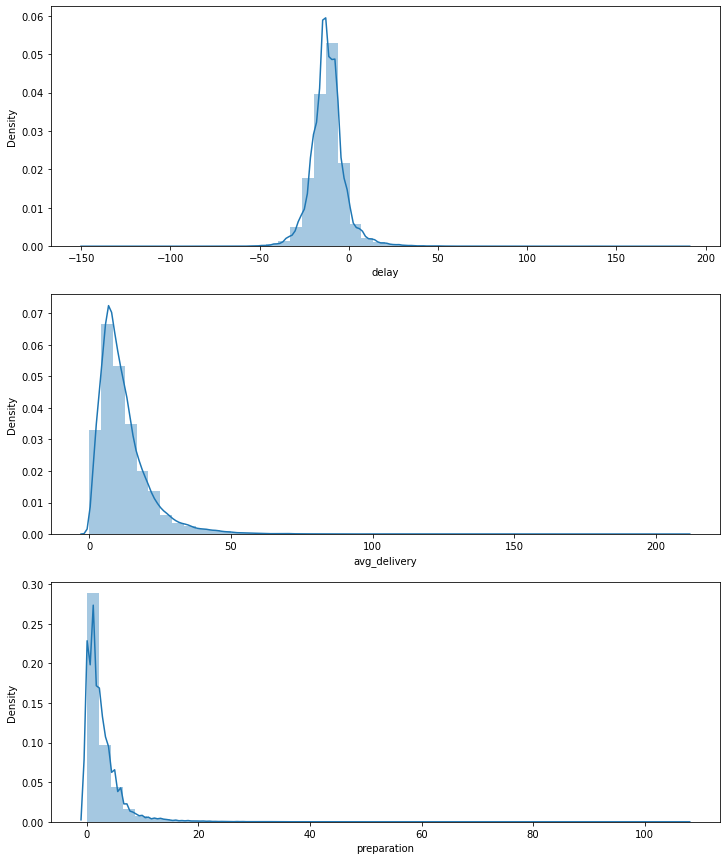

In [1154]:
f,ax = plt.subplots(3, 1, figsize = (12,15))

sns.distplot(df['delay'], ax=ax[0])
sns.distplot(df['avg_delivery'], ax=ax[1])
sns.distplot(df['preparation'], ax=ax[2])

#### order_delivered_carrier_date, order_delivered_customer_date 결측치 처리

In [1155]:
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                13   
order_delivered_carrier_date     929  
order_delivered_customer_date    2043 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             82163
review_comment_message           54958
review_creation_date             0    
new_category                     0    
geolocation_state                0    
delay                            2043 
avg_delivery                     2043 
preparation                      929  
dtype: int64

In [1156]:
# 'order_delivered_carrier_date'가 결측치인 경우의 order_status 확인
df[df['order_delivered_carrier_date'].isnull()].order_status.value_counts()

canceled      362
processing    283
invoiced      280
approved      2  
delivered     2  
Name: order_status, dtype: int64

In [1157]:
# 해당 데이터의 'order_purchase_timestamp'는 2017-01-11부터 2018-08-24 사이에 분포하고 있음
df[df['order_delivered_carrier_date'].isnull()].order_purchase_timestamp.describe()

count     929                
unique    929                
top       2018-01-17 17:09:02
freq      1                  
first     2017-01-11 15:18:25
last      2018-08-24 06:58:50
Name: order_purchase_timestamp, dtype: object

In [1158]:
# 최근 주문 건은 단순히 배송접수가 아직 되지 않은 경우일 것으로 보이나,
# 주문일로부터 몇개월이 지난 건들은 현재 canceled 상태가 아니더라도 배송 가능성이 희박할 것으로 보임
df[df['order_delivered_carrier_date'].isnull()].order_purchase_timestamp.sort_values().tail()

# 그러나 임의로 'order_delivered_carrier_date'나 'order_delivered_customer_date'에 특정 일자를 넣어 
# delay, avg_delivery, preparation을 계산하는 것도 부적절할 것으로 판단하여 해당 데이터는 결측치로 두고 진행키로 함

48088   2018-08-15 22:39:11
67858   2018-08-16 13:07:32
34172   2018-08-16 19:28:02
69375   2018-08-17 00:55:54
89868   2018-08-24 06:58:50
Name: order_purchase_timestamp, dtype: datetime64[ns]

<AxesSubplot:xlabel='order_status', ylabel='preparation'>

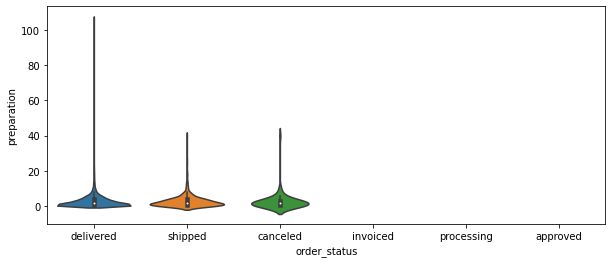

In [1159]:
plt.figure(figsize = (10,4))
sns.violinplot(x = 'order_status', y = 'preparation', data = df)

### 'error' 컬럼 만들기

In [1160]:
# 완료일 - 예정일을 계산한 delay 컬럼값이 0 이상인 건은 배송예정일보다 늦게 도착한 건으로, review_score가 낮을 것으로 예상
df[df['delay'] > 0].review_score.value_counts()

1    3394
5    1034
3    689 
4    631 
2    543 
Name: review_score, dtype: int64

In [1161]:
# 'error' 컬럼 만들어서 delay 컬럼값이 0보다 크거나 결측치인 경우 1로 표시, 나머지 데이터는 0으로 표시
df['error'] = 0
df.loc[(df['delay'] > 0) | (df['delay'].isnull()), 'error'] = 1
df.head()

,order_id,product_id,seller_id,price,freight_value,num,revenue,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,new_category,geolocation_state,delay,avg_delivery,preparation,error
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,1.0,72.19,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21,stationery,RJ,-9.0,7.0,6.0,0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,1.0,259.83,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13,pet,SP,-3.0,16.0,8.0,0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,1.0,216.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.,2018-01-23,furniture,MG,-14.0,7.0,1.0,0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,1.0,25.78,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15,beauty,SP,-6.0,6.0,2.0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,1.0,218.04,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02,garden_tools,PR,-16.0,25.0,11.0,0


In [1162]:
df['error'].value_counts()

0    84809
1    8334 
Name: error, dtype: int64

### 'order_status' 컬럼 원핫인코딩

In [1163]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
order_status = pd.DataFrame(df['order_status'])
ohe_done = ohe.fit_transform(order_status)

In [1164]:
ohe.categories_

[array(['approved', 'canceled', 'delivered', 'invoiced', 'processing',
        'shipped'], dtype=object)]

In [1165]:
ohe_columns = []
for cat in ohe.categories_:
    ohe_columns += cat.tolist()

ohe_order_status = pd.DataFrame(ohe_done, columns=ohe_columns)
ohe_order_status

,approved,canceled,delivered,invoiced,processing,shipped
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
93138,0.0,0.0,1.0,0.0,0.0,0.0
93139,0.0,0.0,1.0,0.0,0.0,0.0
93140,0.0,0.0,1.0,0.0,0.0,0.0
93141,0.0,0.0,1.0,0.0,0.0,0.0


In [1166]:
df = df.reset_index(drop = True)
df = pd.concat([df, ohe_order_status], axis=1)
df = df.drop(columns='order_status')
df

,order_id,product_id,seller_id,price,freight_value,num,revenue,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,new_category,geolocation_state,delay,avg_delivery,preparation,error,approved,canceled,delivered,invoiced,processing,shipped
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,1.0,72.19,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21,stationery,RJ,-9.0,7.0,6.0,0,0.0,0.0,1.0,0.0,0.0,0.0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,1.0,259.83,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13,pet,SP,-3.0,16.0,8.0,0,0.0,0.0,1.0,0.0,0.0,0.0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,1.0,216.87,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.,2018-01-23,furniture,MG,-14.0,7.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,1.0,25.78,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15,beauty,SP,-6.0,6.0,2.0,0,0.0,0.0,1.0,0.0,0.0,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,1.0,218.04,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02,garden_tools,PR,-16.0,25.0,11.0,0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93138,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,1.0,343.40,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,2018-04,9185f849f32d82e216a4e025e0c50f5c,5,NaN,NaN,2018-05-11,home_appliances,SC,-8.0,17.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0
93139,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53,1.0,386.53,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,2018-07,be803f6a93d64719fd685c1cc610918a,5,NaN,NaN,2018-07-24,electronics,SP,-9.0,9.0,2.0,0,0.0,0.0,1.0,0.0,0.0,0.0
93140,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,1.0,116.85,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,2017-10,dbdd81cd59a1a9f94a10a990b4d48dce,5,NaN,NaN,2017-10-29,sports,PR,-13.0,4.0,2.0,0,0.0,0.0,1.0,0.0,0.0,0.0
93141,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,1.0,64.71,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,2017-08,fba117c9ac40d41ca7be54741f471303,5,NaN,Recebi o produto antes do prazo e corretamente.,2017-08-17,electronics,SP,-9.0,1.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0


### 'review_score' 컬럼 원핫인코딩

In [1167]:
review_score = pd.DataFrame(df['review_score'].astype(object))
ohe_done_review = ohe.fit_transform(review_score)

In [1168]:
ohe_columns = []
for cat in ohe.categories_:
    ohe_columns += cat.tolist()

ohe_review_score = pd.DataFrame(ohe_done_review, columns=['1','2','3','4','5'])
ohe_review_score

,1,2,3,4,5
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
93138,0.0,0.0,0.0,0.0,1.0
93139,0.0,0.0,0.0,0.0,1.0
93140,0.0,0.0,0.0,0.0,1.0
93141,0.0,0.0,0.0,0.0,1.0


In [1169]:
df = df.reset_index(drop = True)
df = pd.concat([df, ohe_review_score], axis=1)
df

,order_id,product_id,seller_id,price,freight_value,num,revenue,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,new_category,geolocation_state,delay,avg_delivery,preparation,error,approved,canceled,delivered,invoiced,processing,shipped,1,2,3,4,5
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,1.0,72.19,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21,stationery,RJ,-9.0,7.0,6.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,1.0,259.83,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13,pet,SP,-3.0,16.0,8.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,1.0,216.87,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.,2018-01-23,furniture,MG,-14.0,7.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,1.0,25.78,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15,beauty,SP,-6.0,6.0,2.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,1.0,218.04,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02,garden_tools,PR,-16.0,25.0,11.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93138,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,1.0,343.40,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,2018-04,9185f849f32d82e216a4e025e0c50f5c,5,NaN,NaN,2018-05-11,home_appliances,SC,-8.0,17.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
93139,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53,1.0,386.53,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,2018-07,be803f6a93d64719fd685c1cc610918a,5,NaN,NaN,2018-07-24,electronics,SP,-9.0,9.0,2.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
93140,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,1.0,116.85,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,2017-10,dbdd81cd59a1a9f94a10a990b4d48dce,5,NaN,NaN,2017-10-29,sports,PR,-13.0,4.0,2.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
93141,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,1.0,64.71,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,2017-08,fba117c9ac40d41ca7be54741f471303,5,NaN,Recebi o produto antes do prazo e corretamente.,2017-08-17,electronics,SP,-9.0,1.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# 모델을 위한 최종 데이터셋 만들기

In [1170]:
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
order_purchase_timestamp         0    
order_approved_at                13   
order_delivered_carrier_date     929  
order_delivered_customer_date    2043 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             82163
review_comment_message           54958
review_creation_date             0    
new_category                     0    
geolocation_state                0    
delay                            2043 
avg_delivery                     2043 
preparation                      929  
error                            0    
approved                         0    
canceled                 

## 셀러별, 월별, 제품별 groupby로 묶기

In [1171]:
df_model = df.groupby(['seller_id', 'purchase_month', 'new_category', 'geolocation_state']).agg({'order_id' : 'count',
                                                                 'revenue' : 'sum',
                                                                 'review_score' : 'mean',
                                                                 'delay' : 'mean',
                                                                 'avg_delivery' : 'mean',
                                                                 'preparation' : 'mean',
                                                                 'error' : 'mean',
                                                                 'canceled' : 'sum',
                                                                 'delivered' : 'sum',
                                                                 '1' : 'sum',
                                                                 '2' : 'sum',
                                                                 '3' : 'sum',
                                                                 '4' : 'sum',
                                                                 '5' : 'sum'}).rename(columns = {
    'order_id':'order_nb', 'error' : 'error_rate'}).reset_index()
df_model

,seller_id,purchase_month,new_category,geolocation_state,order_nb,revenue,review_score,delay,avg_delivery,preparation,error_rate,canceled,delivered,1,2,3,4,5
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09,home_appliances,SP,1,916.02,5.000000,-23.000000,10.000000,2.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,home_appliances,SP,2,1832.04,3.000000,-13.000000,10.500000,3.500000,0.000000,0.0,2.0,1.0,0.0,0.0,0.0,1.0
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02,garden_tools,ES,5,1295.40,4.200000,-18.200000,15.800000,2.600000,0.000000,0.0,5.0,0.0,1.0,0.0,1.0,3.0
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03,garden_tools,ES,11,2124.00,3.454545,-10.636364,12.818182,2.636364,0.090909,0.0,11.0,2.0,2.0,1.0,1.0,5.0
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04,garden_tools,ES,13,2068.69,4.000000,-13.416667,11.916667,1.076923,0.153846,0.0,12.0,2.0,0.0,2.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21912,ffff564a4f9085cd26170f4732393726,2017-03,auto,SP,4,618.18,2.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,2.0,0.0,0.0
21913,ffff564a4f9085cd26170f4732393726,2017-03,construction,SP,1,126.69,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0
21914,ffff564a4f9085cd26170f4732393726,2017-03,food_drink,SP,2,141.07,1.000000,NaN,NaN,NaN,1.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0
21915,ffff564a4f9085cd26170f4732393726,2017-03,home_appliances,SP,2,96.60,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,0.0,0.0,0.0


## 'canceled_rate' 컬럼 생성

In [1172]:
df_model['canceled_rate'] = df_model['canceled'] / df_model['order_nb']
df_model

,seller_id,purchase_month,new_category,geolocation_state,order_nb,revenue,review_score,delay,avg_delivery,preparation,error_rate,canceled,delivered,1,2,3,4,5,canceled_rate
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09,home_appliances,SP,1,916.02,5.000000,-23.000000,10.000000,2.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,home_appliances,SP,2,1832.04,3.000000,-13.000000,10.500000,3.500000,0.000000,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.00
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02,garden_tools,ES,5,1295.40,4.200000,-18.200000,15.800000,2.600000,0.000000,0.0,5.0,0.0,1.0,0.0,1.0,3.0,0.00
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03,garden_tools,ES,11,2124.00,3.454545,-10.636364,12.818182,2.636364,0.090909,0.0,11.0,2.0,2.0,1.0,1.0,5.0,0.00
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04,garden_tools,ES,13,2068.69,4.000000,-13.416667,11.916667,1.076923,0.153846,0.0,12.0,2.0,0.0,2.0,1.0,8.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21912,ffff564a4f9085cd26170f4732393726,2017-03,auto,SP,4,618.18,2.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.25
21913,ffff564a4f9085cd26170f4732393726,2017-03,construction,SP,1,126.69,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.00
21914,ffff564a4f9085cd26170f4732393726,2017-03,food_drink,SP,2,141.07,1.000000,NaN,NaN,NaN,1.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00
21915,ffff564a4f9085cd26170f4732393726,2017-03,home_appliances,SP,2,96.60,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.50


## 'revenue_per_order' 컬럼 생성

In [1173]:
df_model['revenue_per_order'] = df_model['revenue'] / df_model['order_nb']
df_model

,seller_id,purchase_month,new_category,geolocation_state,order_nb,revenue,review_score,delay,avg_delivery,preparation,error_rate,canceled,delivered,1,2,3,4,5,canceled_rate,revenue_per_order
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09,home_appliances,SP,1,916.02,5.000000,-23.000000,10.000000,2.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,916.020000
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,home_appliances,SP,2,1832.04,3.000000,-13.000000,10.500000,3.500000,0.000000,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.00,916.020000
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02,garden_tools,ES,5,1295.40,4.200000,-18.200000,15.800000,2.600000,0.000000,0.0,5.0,0.0,1.0,0.0,1.0,3.0,0.00,259.080000
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03,garden_tools,ES,11,2124.00,3.454545,-10.636364,12.818182,2.636364,0.090909,0.0,11.0,2.0,2.0,1.0,1.0,5.0,0.00,193.090909
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04,garden_tools,ES,13,2068.69,4.000000,-13.416667,11.916667,1.076923,0.153846,0.0,12.0,2.0,0.0,2.0,1.0,8.0,0.00,159.130000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21912,ffff564a4f9085cd26170f4732393726,2017-03,auto,SP,4,618.18,2.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.25,154.545000
21913,ffff564a4f9085cd26170f4732393726,2017-03,construction,SP,1,126.69,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.00,126.690000
21914,ffff564a4f9085cd26170f4732393726,2017-03,food_drink,SP,2,141.07,1.000000,NaN,NaN,NaN,1.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,70.535000
21915,ffff564a4f9085cd26170f4732393726,2017-03,home_appliances,SP,2,96.60,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.50,48.300000


## 'satisfied_rate' 컬럼 생성

In [1174]:
df_model['satisfied_rate'] = df_model['5'] / df_model['order_nb']
df_model

,seller_id,purchase_month,new_category,geolocation_state,order_nb,revenue,review_score,delay,avg_delivery,preparation,error_rate,canceled,delivered,1,2,3,4,5,canceled_rate,revenue_per_order,satisfied_rate
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09,home_appliances,SP,1,916.02,5.000000,-23.000000,10.000000,2.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,916.020000,1.000000
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,home_appliances,SP,2,1832.04,3.000000,-13.000000,10.500000,3.500000,0.000000,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.00,916.020000,0.500000
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02,garden_tools,ES,5,1295.40,4.200000,-18.200000,15.800000,2.600000,0.000000,0.0,5.0,0.0,1.0,0.0,1.0,3.0,0.00,259.080000,0.600000
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03,garden_tools,ES,11,2124.00,3.454545,-10.636364,12.818182,2.636364,0.090909,0.0,11.0,2.0,2.0,1.0,1.0,5.0,0.00,193.090909,0.454545
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04,garden_tools,ES,13,2068.69,4.000000,-13.416667,11.916667,1.076923,0.153846,0.0,12.0,2.0,0.0,2.0,1.0,8.0,0.00,159.130000,0.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21912,ffff564a4f9085cd26170f4732393726,2017-03,auto,SP,4,618.18,2.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.25,154.545000,0.000000
21913,ffff564a4f9085cd26170f4732393726,2017-03,construction,SP,1,126.69,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.00,126.690000,0.000000
21914,ffff564a4f9085cd26170f4732393726,2017-03,food_drink,SP,2,141.07,1.000000,NaN,NaN,NaN,1.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,70.535000,0.000000
21915,ffff564a4f9085cd26170f4732393726,2017-03,home_appliances,SP,2,96.60,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.50,48.300000,0.000000


## 'unsatisfied_rate' 컬럼 생성 (새로운 목표변수로 사용)

In [1175]:
df_model['unsatisfied_rate'] = (df_model['1'] + df_model['2'] + df_model['3'])/ df_model['order_nb']
df_model

,seller_id,purchase_month,new_category,geolocation_state,order_nb,revenue,review_score,delay,avg_delivery,preparation,error_rate,canceled,delivered,1,2,3,4,5,canceled_rate,revenue_per_order,satisfied_rate,unsatisfied_rate
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09,home_appliances,SP,1,916.02,5.000000,-23.000000,10.000000,2.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,916.020000,1.000000,0.000000
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,home_appliances,SP,2,1832.04,3.000000,-13.000000,10.500000,3.500000,0.000000,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.00,916.020000,0.500000,0.500000
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02,garden_tools,ES,5,1295.40,4.200000,-18.200000,15.800000,2.600000,0.000000,0.0,5.0,0.0,1.0,0.0,1.0,3.0,0.00,259.080000,0.600000,0.200000
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03,garden_tools,ES,11,2124.00,3.454545,-10.636364,12.818182,2.636364,0.090909,0.0,11.0,2.0,2.0,1.0,1.0,5.0,0.00,193.090909,0.454545,0.454545
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04,garden_tools,ES,13,2068.69,4.000000,-13.416667,11.916667,1.076923,0.153846,0.0,12.0,2.0,0.0,2.0,1.0,8.0,0.00,159.130000,0.615385,0.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21912,ffff564a4f9085cd26170f4732393726,2017-03,auto,SP,4,618.18,2.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.25,154.545000,0.000000,1.000000
21913,ffff564a4f9085cd26170f4732393726,2017-03,construction,SP,1,126.69,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.00,126.690000,0.000000,1.000000
21914,ffff564a4f9085cd26170f4732393726,2017-03,food_drink,SP,2,141.07,1.000000,NaN,NaN,NaN,1.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,70.535000,0.000000,1.000000
21915,ffff564a4f9085cd26170f4732393726,2017-03,home_appliances,SP,2,96.60,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.50,48.300000,0.000000,1.000000


## 목표변수 분리

In [1176]:
# 목표변수 분리
label = df_model['unsatisfied_rate']

<AxesSubplot:>

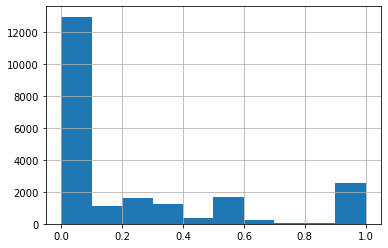

In [1177]:
label.hist()

## 목표변수와 입력변수 간 관계 확인

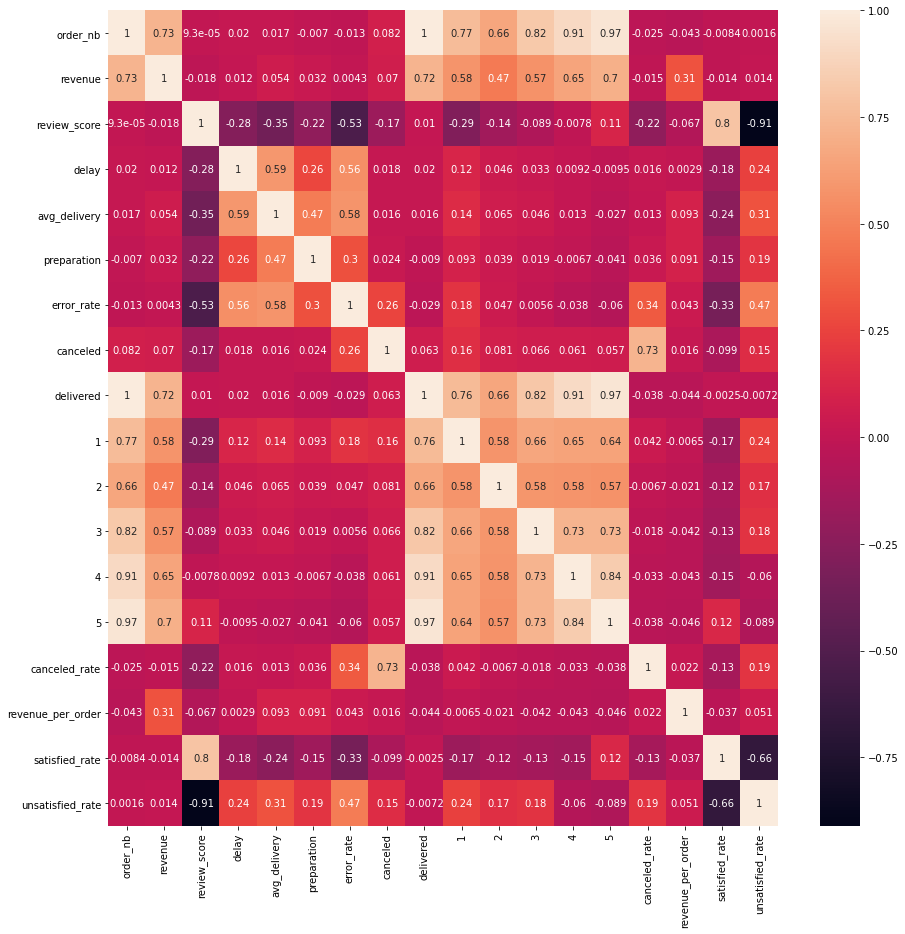

In [1178]:
plt.figure(figsize = (15,15))
plt.yticks(rotation = 0)
g = sns.heatmap(df_model.corr(), annot = True)

<AxesSubplot:xlabel='purchase_month', ylabel='unsatisfied_rate'>

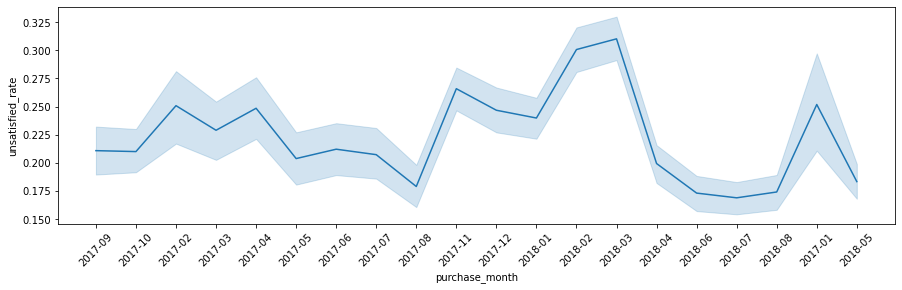

In [1179]:
plt.figure(figsize = (15,4))
plt.xticks(rotation = 45)
sns.lineplot(data = df_model, x = 'purchase_month', y = 'unsatisfied_rate')

<AxesSubplot:xlabel='geolocation_state', ylabel='unsatisfied_rate'>

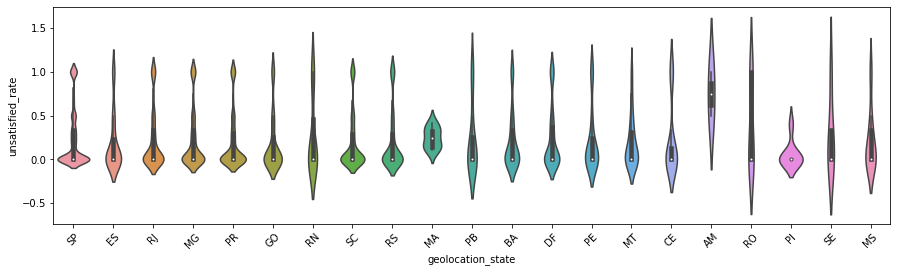

In [1180]:
plt.figure(figsize = (15,4))
plt.xticks(rotation = 45)
sns.violinplot(data = df_model, x = 'geolocation_state', y = 'unsatisfied_rate')

## 모델 미사용 컬럼 제거 및 데이터셋 복제

In [1181]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21917 entries, 0 to 21916
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seller_id          21917 non-null  object 
 1   purchase_month     21917 non-null  object 
 2   new_category       21917 non-null  object 
 3   geolocation_state  21917 non-null  object 
 4   order_nb           21917 non-null  int64  
 5   revenue            21917 non-null  float64
 6   review_score       21917 non-null  float64
 7   delay              21438 non-null  float64
 8   avg_delivery       21438 non-null  float64
 9   preparation        21544 non-null  float64
 10  error_rate         21917 non-null  float64
 11  canceled           21917 non-null  float64
 12  delivered          21917 non-null  float64
 13  1                  21917 non-null  float64
 14  2                  21917 non-null  float64
 15  3                  21917 non-null  float64
 16  4                  219

In [1182]:
# 미사용 컬럼 제거
df_final = df_model.drop(['purchase_month', 'new_category', 'order_nb', 'revenue', 'review_score', 'canceled', 'delivered',
                          '1','2','3','4','5', 'unsatisfied_rate', 'satisfied_rate'], axis = 1)
df_final

,seller_id,geolocation_state,delay,avg_delivery,preparation,error_rate,canceled_rate,revenue_per_order
0,0015a82c2db000af6aaaf3ae2ecb0532,SP,-23.000000,10.000000,2.000000,0.000000,0.00,916.020000
1,0015a82c2db000af6aaaf3ae2ecb0532,SP,-13.000000,10.500000,3.500000,0.000000,0.00,916.020000
2,001cca7ae9ae17fb1caed9dfb1094831,ES,-18.200000,15.800000,2.600000,0.000000,0.00,259.080000
3,001cca7ae9ae17fb1caed9dfb1094831,ES,-10.636364,12.818182,2.636364,0.090909,0.00,193.090909
4,001cca7ae9ae17fb1caed9dfb1094831,ES,-13.416667,11.916667,1.076923,0.153846,0.00,159.130000
...,...,...,...,...,...,...,...,...
21912,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,0.25,154.545000
21913,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,1.00,126.690000
21914,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,0.00,70.535000
21915,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,0.50,48.300000


In [1183]:
# 인코딩 실험을 위해 df_le, df_ohe로 복제
df_le = df_final.copy()
df_ohe = df_final.copy()

## geolocation_state 라벨인코딩

In [1184]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_le['geolocation_state'] = le.fit_transform(df_le['geolocation_state'])

In [1185]:
df_le.describe()

,geolocation_state,delay,avg_delivery,preparation,error_rate,canceled_rate,revenue_per_order
count,21917.000000,21438.000000,21438.000000,21544.000000,21917.000000,21917.000000,21917.000000
mean,16.957613,-12.117707,11.829445,2.786770,0.096649,0.009569,185.117796
std,4.888059,9.319713,8.406952,3.616121,0.246868,0.088617,286.764480
min,0.000000,-147.000000,0.000000,0.000000,0.000000,0.000000,10.070000
25%,14.000000,-16.500000,7.000000,1.000000,0.000000,0.000000,65.253333
50%,20.000000,-12.000000,10.000000,2.000000,0.000000,0.000000,111.716667
75%,20.000000,-8.000000,14.500000,3.333333,0.000000,0.000000,193.650000
max,20.000000,175.000000,195.000000,107.000000,1.000000,1.000000,13664.080000


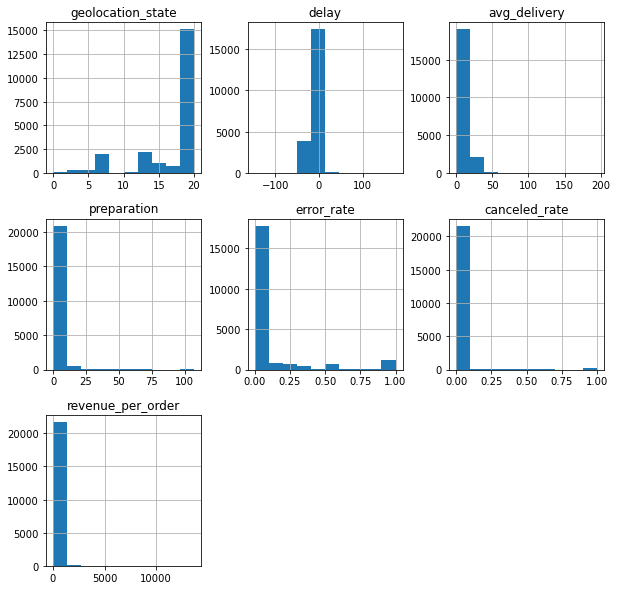

In [1186]:
g = df_le.hist(figsize = (10,10))

## 범주형, 연속형 컬럼 분리

In [1187]:
# 라벨인코딩
cat_columns = [c for c, t in zip(df_le.dtypes.index, df_le.dtypes) if t == 'O']
num_columns = [c for c in df_le.columns if c not in cat_columns]
print('Categorical Columns:\n{}\n\n Numeric Columns:\n{}\n'.format(cat_columns, num_columns))

Categorical Columns:
['seller_id']

 Numeric Columns:
['geolocation_state', 'delay', 'avg_delivery', 'preparation', 'error_rate', 'canceled_rate', 'revenue_per_order']



In [1188]:
# 원핫인코딩
cat_columns = [c for c, t in zip(df_ohe.dtypes.index, df_ohe.dtypes) if t == 'O']
num_columns = [c for c in df_ohe.columns if c not in cat_columns]
print('Categorical Columns:\n{}\n\n Numeric Columns:\n{}\n'.format(cat_columns, num_columns))

Categorical Columns:
['seller_id', 'geolocation_state']

 Numeric Columns:
['delay', 'avg_delivery', 'preparation', 'error_rate', 'canceled_rate', 'revenue_per_order']



## 전처리 함수

### 연속형 변수 처리x

In [1189]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

def preprocess(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)
    
#     # num_columns 스케일링
#     scaler = StandardScaler()
#     tmp_x_train[num_columns] = scaler.fit_transform(tmp_x_train[num_columns])
#     tmp_x_test[num_columns] = scaler.transform(tmp_x_test[num_columns])
        
    # cat_columns 원핫인코딩
    ohe = OneHotEncoder(sparse=False)
    x_all = pd.concat([tmp_x_train[cat_columns], 
                       tmp_x_test[cat_columns]], axis=0)

    new_x_all = ohe.fit_transform(x_all)
    
    ohe_columns = []
    for cat in ohe.categories_:
        ohe_columns += cat.tolist()
    
    new_x_all = pd.DataFrame(new_x_all, columns=ohe_columns)

    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

### 연속형 변수 MinMaxScaler 처리

In [1190]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

def preprocess_norm(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)
    
    # num_columns 스케일링
    scaler = MinMaxScaler()
    tmp_x_train[num_columns] = scaler.fit_transform(tmp_x_train[num_columns])
    tmp_x_test[num_columns] = scaler.transform(tmp_x_test[num_columns])
        
    # cat_columns 원핫인코딩
    ohe = OneHotEncoder(sparse=False)
    x_all = pd.concat([tmp_x_train[cat_columns], 
                       tmp_x_test[cat_columns]], axis=0)

    new_x_all = ohe.fit_transform(x_all)
    
    ohe_columns = []
    for cat in ohe.categories_:
        ohe_columns += cat.tolist()
    
    new_x_all = pd.DataFrame(new_x_all, columns=ohe_columns)

    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

# 모형을 통한 예측

## train, test set 분리

In [1191]:
# LabelEncoding 데이터
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_le, label, test_size=0.3,
                                                       random_state=2021,
                                                       shuffle=True)

In [1192]:
x_train.shape, x_test.shape

((15341, 8), (6576, 8))

In [1193]:
# OneHotEncoding 데이터
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_ohe, label, test_size=0.3,
                                                       random_state=2021,
                                                       shuffle=True)

In [1194]:
x_train.shape, x_test.shape

((15341, 8), (6576, 8))

### 입력변수 전처리

In [1195]:
# 연속형 변수 처리x
x_train, x_test = preprocess(x_train, x_test)

In [1196]:
# 연속형 변수 MinMaxScaler 처리
x_train, x_test = preprocess_norm(x_train, x_test)

KeyError: "None of [Index(['seller_id', 'geolocation_state'], dtype='object')] are in the [columns]"

In [ ]:
x_train.shape, x_test.shape

In [ ]:
x_train.describe()

## 모델 예측

### state 라벨인코딩, 연속형변수 전처리 x

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

models = [['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

### state 라벨인코딩, 연속형변수 minmaxscaler 전처리

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

models = [['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

### state 원핫인코딩, 연속형변수 전처리 x

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

models = [['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

### state 원핫인코딩, 연속형변수 minmaxscaler 전처리

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

models = [['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

### seller_id 사용,  state 원핫인코딩, 연속형변수 전처리x

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

models = [['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

# best model 확인

In [ ]:
best_model = models[1][1]
best_model

In [ ]:
best_model.feature_importances_

In [ ]:
pd.DataFrame(sorted(zip(best_model.feature_importances_, x_train.columns)), columns=['Value','Feature'])

In [ ]:
pd.DataFrame(sorted(zip(best_model.feature_importances_, x_train.columns), reverse=True), columns=['Value','Feature'])

In [ ]:
# Feature importance
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

# 셀러 등급 분류

## 셀러별 데이터 확인

In [1237]:
temp = df.groupby(['seller_id', 'purchase_month', 'new_category', 'geolocation_state'])['order_purchase_timestamp'].agg(
    ['max','min']).reset_index()
temp

,seller_id,purchase_month,new_category,geolocation_state,max,min
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09,home_appliances,SP,2017-09-26 22:17:05,2017-09-26 22:17:05
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,home_appliances,SP,2017-10-18 08:16:34,2017-10-12 13:33:22
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02,garden_tools,ES,2017-02-27 23:54:11,2017-02-04 19:06:04
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03,garden_tools,ES,2017-03-31 15:41:59,2017-03-02 16:12:33
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04,garden_tools,ES,2017-04-30 17:45:21,2017-04-02 18:52:07
...,...,...,...,...,...,...
21912,ffff564a4f9085cd26170f4732393726,2017-03,auto,SP,2017-03-29 19:56:47,2017-03-14 22:01:28
21913,ffff564a4f9085cd26170f4732393726,2017-03,construction,SP,2017-03-14 09:27:08,2017-03-14 09:27:08
21914,ffff564a4f9085cd26170f4732393726,2017-03,food_drink,SP,2017-03-15 10:30:17,2017-03-13 13:32:46
21915,ffff564a4f9085cd26170f4732393726,2017-03,home_appliances,SP,2017-03-24 00:24:17,2017-03-14 20:12:18


In [1238]:
df_model_dates = df_model.merge(temp, on = ['seller_id', 'purchase_month','new_category', 'geolocation_state'], how = 'inner')
df_model_dates

,seller_id,purchase_month,new_category,geolocation_state,order_nb,revenue,review_score,delay,avg_delivery,preparation,error_rate,canceled,delivered,1,2,3,4,5,canceled_rate,revenue_per_order,satisfied_rate,unsatisfied_rate,max,min
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09,home_appliances,SP,1,916.02,5.000000,-23.000000,10.000000,2.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,916.020000,1.000000,0.000000,2017-09-26 22:17:05,2017-09-26 22:17:05
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,home_appliances,SP,2,1832.04,3.000000,-13.000000,10.500000,3.500000,0.000000,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.00,916.020000,0.500000,0.500000,2017-10-18 08:16:34,2017-10-12 13:33:22
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02,garden_tools,ES,5,1295.40,4.200000,-18.200000,15.800000,2.600000,0.000000,0.0,5.0,0.0,1.0,0.0,1.0,3.0,0.00,259.080000,0.600000,0.200000,2017-02-27 23:54:11,2017-02-04 19:06:04
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03,garden_tools,ES,11,2124.00,3.454545,-10.636364,12.818182,2.636364,0.090909,0.0,11.0,2.0,2.0,1.0,1.0,5.0,0.00,193.090909,0.454545,0.454545,2017-03-31 15:41:59,2017-03-02 16:12:33
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04,garden_tools,ES,13,2068.69,4.000000,-13.416667,11.916667,1.076923,0.153846,0.0,12.0,2.0,0.0,2.0,1.0,8.0,0.00,159.130000,0.615385,0.307692,2017-04-30 17:45:21,2017-04-02 18:52:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21912,ffff564a4f9085cd26170f4732393726,2017-03,auto,SP,4,618.18,2.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.25,154.545000,0.000000,1.000000,2017-03-29 19:56:47,2017-03-14 22:01:28
21913,ffff564a4f9085cd26170f4732393726,2017-03,construction,SP,1,126.69,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.00,126.690000,0.000000,1.000000,2017-03-14 09:27:08,2017-03-14 09:27:08
21914,ffff564a4f9085cd26170f4732393726,2017-03,food_drink,SP,2,141.07,1.000000,NaN,NaN,NaN,1.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,70.535000,0.000000,1.000000,2017-03-15 10:30:17,2017-03-13 13:32:46
21915,ffff564a4f9085cd26170f4732393726,2017-03,home_appliances,SP,2,96.60,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.50,48.300000,0.000000,1.000000,2017-03-24 00:24:17,2017-03-14 20:12:18


In [1239]:
df_model_dates = df_model_dates.rename(columns = {'max' : 'last_sales', 'min' : 'first_sales'})
df_model_dates

,seller_id,purchase_month,new_category,geolocation_state,order_nb,revenue,review_score,delay,avg_delivery,preparation,error_rate,canceled,delivered,1,2,3,4,5,canceled_rate,revenue_per_order,satisfied_rate,unsatisfied_rate,last_sales,first_sales
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09,home_appliances,SP,1,916.02,5.000000,-23.000000,10.000000,2.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,916.020000,1.000000,0.000000,2017-09-26 22:17:05,2017-09-26 22:17:05
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,home_appliances,SP,2,1832.04,3.000000,-13.000000,10.500000,3.500000,0.000000,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.00,916.020000,0.500000,0.500000,2017-10-18 08:16:34,2017-10-12 13:33:22
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02,garden_tools,ES,5,1295.40,4.200000,-18.200000,15.800000,2.600000,0.000000,0.0,5.0,0.0,1.0,0.0,1.0,3.0,0.00,259.080000,0.600000,0.200000,2017-02-27 23:54:11,2017-02-04 19:06:04
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03,garden_tools,ES,11,2124.00,3.454545,-10.636364,12.818182,2.636364,0.090909,0.0,11.0,2.0,2.0,1.0,1.0,5.0,0.00,193.090909,0.454545,0.454545,2017-03-31 15:41:59,2017-03-02 16:12:33
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04,garden_tools,ES,13,2068.69,4.000000,-13.416667,11.916667,1.076923,0.153846,0.0,12.0,2.0,0.0,2.0,1.0,8.0,0.00,159.130000,0.615385,0.307692,2017-04-30 17:45:21,2017-04-02 18:52:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21912,ffff564a4f9085cd26170f4732393726,2017-03,auto,SP,4,618.18,2.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.25,154.545000,0.000000,1.000000,2017-03-29 19:56:47,2017-03-14 22:01:28
21913,ffff564a4f9085cd26170f4732393726,2017-03,construction,SP,1,126.69,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.00,126.690000,0.000000,1.000000,2017-03-14 09:27:08,2017-03-14 09:27:08
21914,ffff564a4f9085cd26170f4732393726,2017-03,food_drink,SP,2,141.07,1.000000,NaN,NaN,NaN,1.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,70.535000,0.000000,1.000000,2017-03-15 10:30:17,2017-03-13 13:32:46
21915,ffff564a4f9085cd26170f4732393726,2017-03,home_appliances,SP,2,96.60,1.000000,NaN,NaN,NaN,1.000000,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.50,48.300000,0.000000,1.000000,2017-03-24 00:24:17,2017-03-14 20:12:18


In [1240]:
df_seller = df_model_dates.groupby('seller_id')['purchase_month', 'geolocation_state', 'order_nb', 'revenue', 'review_score',
                               'delay', 'avg_delivery', 'preparation', 'error_rate', 'canceled_rate', 'revenue_per_order',
                               'satisfied_rate', 'unsatisfied_rate', 'last_sales', 'first_sales'].agg({
    'purchase_month' : 'max', 'purchase_month' : 'max', 'geolocation_state' : 'max', 'order_nb' : ['sum', 'mean'],
    'revenue' : ['sum', 'mean'], 'review_score' : 'mean', 'delay' : 'mean', 'avg_delivery' : 'mean', 'preparation' : 'mean',
    'error_rate' : 'mean', 'canceled_rate' : 'mean', 'revenue_per_order' : 'mean', 'satisfied_rate' : 'mean', 'unsatisfied_rate' : 'mean',
    'last_sales' : 'max', 'first_sales' : 'min'
})
df_seller

purchase_month geolocation_state order_nb  \
                                            max               max      sum   
seller_id                                                                    
0015a82c2db000af6aaaf3ae2ecb0532  2017-10        SP                3         
001cca7ae9ae17fb1caed9dfb1094831  2018-07        ES                198       
001e6ad469a905060d959994f1b41e4f  2018-08        RJ                1         
002100f778ceb8431b7a1020ff7ab48f  2018-04        SP                44        
004c9cd9d87a3c30c522c48c4fc07416  2018-05        SP                137       
...                                   ...        ..               ..         
ffcfefa19b08742c5d315f2791395ee5  2018-06        PR                1         
ffdd9f82b9a447f6f8d4b91554cc7dd3  2018-08        PR                18        
ffeee66ac5d5a62fe688b9d26f83f534  2018-05        SP                14        
fffd5413c0700ac820c7069d66d98c89  2018-08        SP                56        
ffff564a4f9085cd26170f4732393726  2017-04        SP                16        

                                             revenue               \
                                      mean       sum         mean   
seller_id                                                           
0015a82c2db000af6aaaf3ae2ecb0532  1.500000  2748.06   1374.030000   
001cca7ae9ae17fb1caed9dfb1094831  7.333333  33446.21  1238.748519   
001e6ad469a905060d959994f1b41e4f  1.000000  267.94    267.940000    
002100f778ceb8431b7a1020ff7ab48f  5.500000  1667.75   208.468750    
004c9cd9d87a3c30c522c48c4fc07416  8.058824  19214.56  1130.268235   
...                                    ...     ...           ...    
ffcfefa19b08742c5d315f2791395ee5  1.000000  79.52     79.520000     
ffdd9f82b9a447f6f8d4b91554cc7dd3  1.636364  2828.66   257.150909    
ffeee66ac5d5a62fe688b9d26f83f534  2.000000  2259.55   322.792857    
fffd5413c0700ac820c7069d66d98c89  2.434783  11530.83  501.340435    
ffff564a4f9085cd26170f4732393726  2.285714  1433.19   204.741429    

                                 review_score      delay avg_delivery  \
                                         mean       mean         mean   
seller_id                                                               
0015a82c2db000af6aaaf3ae2ecb0532  4.000000    -18.000000  10.250000     
001cca7ae9ae17fb1caed9dfb1094831  4.113667    -13.009793  13.885837     
001e6ad469a905060d959994f1b41e4f  1.000000    NaN        NaN            
002100f778ceb8431b7a1020ff7ab48f  3.690476    -7.983036   15.467857     
004c9cd9d87a3c30c522c48c4fc07416  4.161262    -13.284333  13.069757     
...                                    ...     ..         ..            
ffcfefa19b08742c5d315f2791395ee5  1.000000    NaN        NaN            
ffdd9f82b9a447f6f8d4b91554cc7dd3  4.393939    -13.015152  9.696970      
ffeee66ac5d5a62fe688b9d26f83f534  3.892857    -6.500000   18.202381     
fffd5413c0700ac820c7069d66d98c89  3.805072    -10.815942  13.760870     
ffff564a4f9085cd26170f4732393726  1.928571    -46.625000  9.000000      

                                 preparation error_rate canceled_rate  \
                                        mean       mean          mean   
seller_id                                                               
0015a82c2db000af6aaaf3ae2ecb0532  2.750000    0.000000   0.000000       
001cca7ae9ae17fb1caed9dfb1094831  2.422261    0.112501   0.000000       
001e6ad469a905060d959994f1b41e4f NaN          1.000000   1.000000       
002100f778ceb8431b7a1020ff7ab48f  3.146131    0.232440   0.000000       
004c9cd9d87a3c30c522c48c4fc07416  1.155570    0.071192   0.000000       
...                               ..               ...        ...       
ffcfefa19b08742c5d315f2791395ee5 NaN          1.000000   1.000000       
ffdd9f82b9a447f6f8d4b91554cc7dd3  3.287879    0.000000   0.000000       
ffeee66ac5d5a62fe688b9d26f83f534  7.583333    0.214286   0.000000       
fffd5413c0700ac820c7069d66d98c89  1.747101    0.177174   0.005435       
f

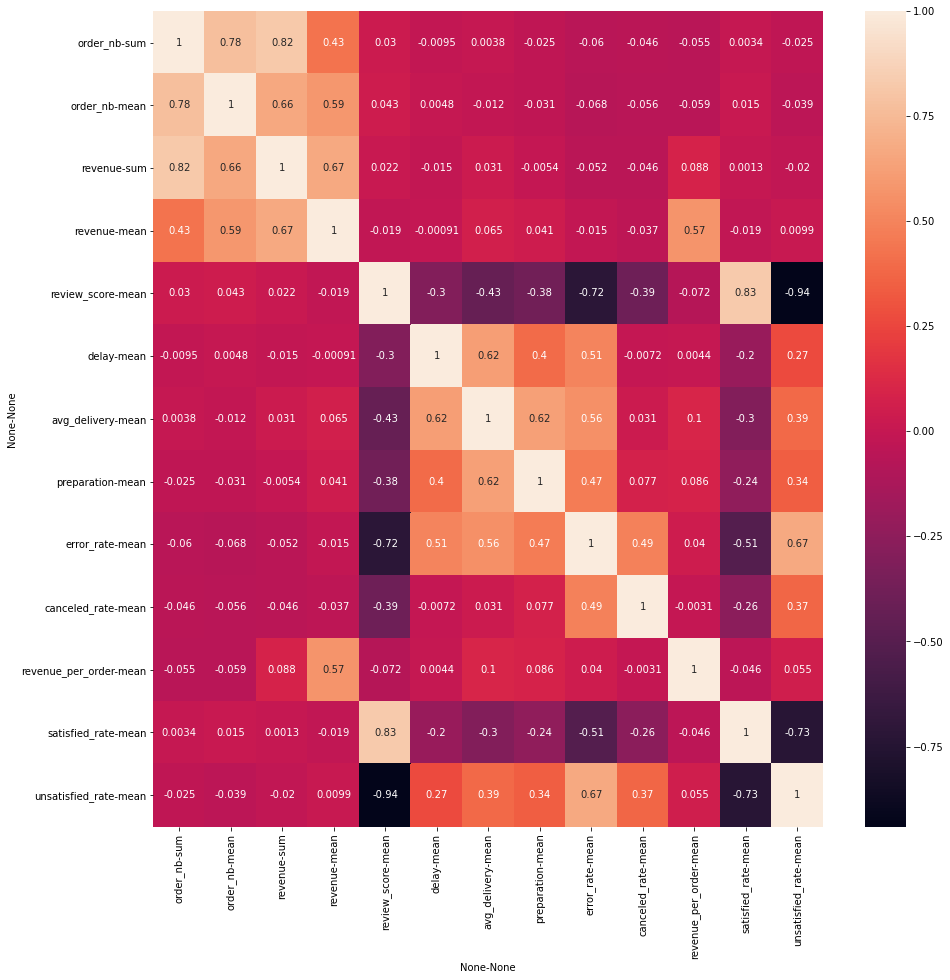

In [1241]:
plt.figure(figsize = (15,15))
plt.yticks(rotation = 0)
g = sns.heatmap(df_seller.corr(), annot = True)

In [1242]:
# 두 레벨로 나눠진 컬럼명 합치기
df_seller.columns = df_seller.columns.map('_'.join).str.strip('_')
df_seller

,purchase_month_max,geolocation_state_max,order_nb_sum,order_nb_mean,revenue_sum,revenue_mean,review_score_mean,delay_mean,avg_delivery_mean,preparation_mean,error_rate_mean,canceled_rate_mean,revenue_per_order_mean,satisfied_rate_mean,unsatisfied_rate_mean,last_sales_max,first_sales_min
seller_id,,,,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,2017-10,SP,3,1.500000,2748.06,1374.030000,4.000000,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,0.750000,0.250000,2017-10-18 08:16:34,2017-09-26 22:17:05
001cca7ae9ae17fb1caed9dfb1094831,2018-07,ES,198,7.333333,33446.21,1238.748519,4.113667,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,0.559577,0.210564,2018-07-12 21:38:26,2017-02-04 19:06:04
001e6ad469a905060d959994f1b41e4f,2018-08,RJ,1,1.000000,267.94,267.940000,1.000000,NaN,NaN,NaN,1.000000,1.000000,267.940000,0.000000,1.000000,2018-08-07 22:50:37,2018-08-07 22:50:37
002100f778ceb8431b7a1020ff7ab48f,2018-04,SP,44,5.500000,1667.75,208.468750,3.690476,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,0.442262,0.445238,2018-04-12 12:58:23,2017-09-14 01:00:31
004c9cd9d87a3c30c522c48c4fc07416,2018-05,SP,137,8.058824,19214.56,1130.268235,4.161262,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,0.645528,0.235832,2018-05-01 18:06:57,2017-01-27 10:34:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffcfefa19b08742c5d315f2791395ee5,2018-06,PR,1,1.000000,79.52,79.520000,1.000000,NaN,NaN,NaN,1.000000,1.000000,79.520000,0.000000,1.000000,2018-06-23 17:34:33,2018-06-23 17:34:33
ffdd9f82b9a447f6f8d4b91554cc7dd3,2018-08,PR,18,1.636364,2828.66,257.150909,4.393939,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,0.636364,0.151515,2018-08-19 14:37:08,2017-03-05 16:21:27
ffeee66ac5d5a62fe688b9d26f83f534,2018-05,SP,14,2.000000,2259.55,322.792857,3.892857,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,0.535714,0.214286,2018-05-14 08:55:22,2017-09-30 15:56:56


In [1243]:
df_seller.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2978 entries, 0015a82c2db000af6aaaf3ae2ecb0532 to ffff564a4f9085cd26170f4732393726
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   purchase_month_max      2978 non-null   object        
 1   geolocation_state_max   2978 non-null   object        
 2   order_nb_sum            2978 non-null   int64         
 3   order_nb_mean           2978 non-null   float64       
 4   revenue_sum             2978 non-null   float64       
 5   revenue_mean            2978 non-null   float64       
 6   review_score_mean       2978 non-null   float64       
 7   delay_mean              2857 non-null   float64       
 8   avg_delivery_mean       2857 non-null   float64       
 9   preparation_mean        2863 non-null   float64       
 10  error_rate_mean         2978 non-null   float64       
 11  canceled_rate_mean      2978 non-null   float64       

In [1244]:
# 마지막 배송일에 1일을 더한 last_timestamp 생성
last_timestamp = df_seller['last_sales_max'].max() + dt.timedelta(days = 1)
last_timestamp

Timestamp('2018-08-30 15:00:37')

In [1245]:
df_seller['recency'] = (last_timestamp - df_seller['last_sales_max']).dt.days
df_seller

,purchase_month_max,geolocation_state_max,order_nb_sum,order_nb_mean,revenue_sum,revenue_mean,review_score_mean,delay_mean,avg_delivery_mean,preparation_mean,error_rate_mean,canceled_rate_mean,revenue_per_order_mean,satisfied_rate_mean,unsatisfied_rate_mean,last_sales_max,first_sales_min,recency
seller_id,,,,,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,2017-10,SP,3,1.500000,2748.06,1374.030000,4.000000,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,0.750000,0.250000,2017-10-18 08:16:34,2017-09-26 22:17:05,316
001cca7ae9ae17fb1caed9dfb1094831,2018-07,ES,198,7.333333,33446.21,1238.748519,4.113667,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,0.559577,0.210564,2018-07-12 21:38:26,2017-02-04 19:06:04,48
001e6ad469a905060d959994f1b41e4f,2018-08,RJ,1,1.000000,267.94,267.940000,1.000000,NaN,NaN,NaN,1.000000,1.000000,267.940000,0.000000,1.000000,2018-08-07 22:50:37,2018-08-07 22:50:37,22
002100f778ceb8431b7a1020ff7ab48f,2018-04,SP,44,5.500000,1667.75,208.468750,3.690476,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,0.442262,0.445238,2018-04-12 12:58:23,2017-09-14 01:00:31,140
004c9cd9d87a3c30c522c48c4fc07416,2018-05,SP,137,8.058824,19214.56,1130.268235,4.161262,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,0.645528,0.235832,2018-05-01 18:06:57,2017-01-27 10:34:34,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffcfefa19b08742c5d315f2791395ee5,2018-06,PR,1,1.000000,79.52,79.520000,1.000000,NaN,NaN,NaN,1.000000,1.000000,79.520000,0.000000,1.000000,2018-06-23 17:34:33,2018-06-23 17:34:33,67
ffdd9f82b9a447f6f8d4b91554cc7dd3,2018-08,PR,18,1.636364,2828.66,257.150909,4.393939,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,0.636364,0.151515,2018-08-19 14:37:08,2017-03-05 16:21:27,11
ffeee66ac5d5a62fe688b9d26f83f534,2018-05,SP,14,2.000000,2259.55,322.792857,3.892857,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,0.535714,0.214286,2018-05-14 08:55:22,2017-09-30 15:56:56,108


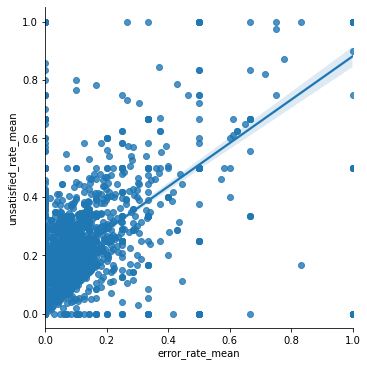

In [1246]:
g = sns.lmplot(data = df_seller, x = 'error_rate_mean', y = 'unsatisfied_rate_mean')

<AxesSubplot:xlabel='purchase_month_max', ylabel='review_score_mean'>

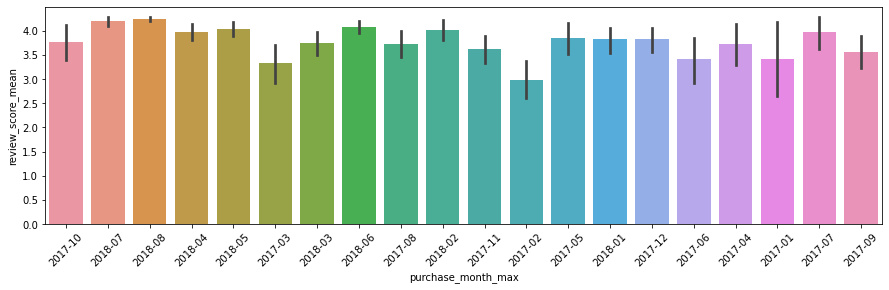

In [1247]:
plt.figure(figsize = (15,4))
plt.xticks(rotation = 45)
sns.barplot(data = df_seller, x = 'purchase_month_max', y = 'review_score_mean')

<AxesSubplot:xlabel='geolocation_state_max', ylabel='review_score_mean'>

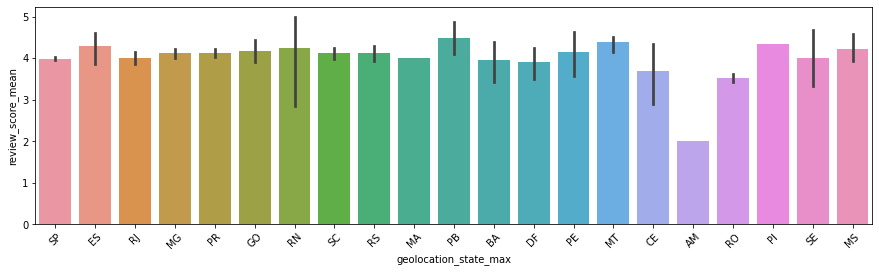

In [1248]:
plt.figure(figsize = (15,4))
plt.xticks(rotation = 45)
sns.barplot(data = df_seller, x = 'geolocation_state_max', y = 'review_score_mean')

## K-means

In [1249]:
df_seller = df_seller.reset_index()
df_seller

,seller_id,purchase_month_max,geolocation_state_max,order_nb_sum,order_nb_mean,revenue_sum,revenue_mean,review_score_mean,delay_mean,avg_delivery_mean,preparation_mean,error_rate_mean,canceled_rate_mean,revenue_per_order_mean,satisfied_rate_mean,unsatisfied_rate_mean,last_sales_max,first_sales_min,recency
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,SP,3,1.500000,2748.06,1374.030000,4.000000,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,0.750000,0.250000,2017-10-18 08:16:34,2017-09-26 22:17:05,316
1,001cca7ae9ae17fb1caed9dfb1094831,2018-07,ES,198,7.333333,33446.21,1238.748519,4.113667,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,0.559577,0.210564,2018-07-12 21:38:26,2017-02-04 19:06:04,48
2,001e6ad469a905060d959994f1b41e4f,2018-08,RJ,1,1.000000,267.94,267.940000,1.000000,NaN,NaN,NaN,1.000000,1.000000,267.940000,0.000000,1.000000,2018-08-07 22:50:37,2018-08-07 22:50:37,22
3,002100f778ceb8431b7a1020ff7ab48f,2018-04,SP,44,5.500000,1667.75,208.468750,3.690476,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,0.442262,0.445238,2018-04-12 12:58:23,2017-09-14 01:00:31,140
4,004c9cd9d87a3c30c522c48c4fc07416,2018-05,SP,137,8.058824,19214.56,1130.268235,4.161262,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,0.645528,0.235832,2018-05-01 18:06:57,2017-01-27 10:34:34,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,ffcfefa19b08742c5d315f2791395ee5,2018-06,PR,1,1.000000,79.52,79.520000,1.000000,NaN,NaN,NaN,1.000000,1.000000,79.520000,0.000000,1.000000,2018-06-23 17:34:33,2018-06-23 17:34:33,67
2974,ffdd9f82b9a447f6f8d4b91554cc7dd3,2018-08,PR,18,1.636364,2828.66,257.150909,4.393939,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,0.636364,0.151515,2018-08-19 14:37:08,2017-03-05 16:21:27,11
2975,ffeee66ac5d5a62fe688b9d26f83f534,2018-05,SP,14,2.000000,2259.55,322.792857,3.892857,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,0.535714,0.214286,2018-05-14 08:55:22,2017-09-30 15:56:56,108
2976,fffd5413c0700ac820c7069d66d98c89,2018-08,SP,56,2.434783,11530.83,501.340435,3.805072,-10.815942,13.760870,1.747101,0.177174,0.005435,213.903935,0.570290,0.296739,2018-08-26 19:56:12,2017-07-24 21:13:55,3


In [1250]:
# Clustering 작업을 위해 필요 정보만 별도 데이터프레임으로 만들기
df_cluster = df_seller[['seller_id', 'geolocation_state_max', 'order_nb_sum', 'revenue_sum', 'delay_mean', 'avg_delivery_mean', 'preparation_mean',
 'error_rate_mean', 'canceled_rate_mean', 'revenue_per_order_mean', 'recency']]
df_cluster

,seller_id,geolocation_state_max,order_nb_sum,revenue_sum,delay_mean,avg_delivery_mean,preparation_mean,error_rate_mean,canceled_rate_mean,revenue_per_order_mean,recency
0,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,2748.06,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,316
1,001cca7ae9ae17fb1caed9dfb1094831,ES,198,33446.21,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,48
2,001e6ad469a905060d959994f1b41e4f,RJ,1,267.94,NaN,NaN,NaN,1.000000,1.000000,267.940000,22
3,002100f778ceb8431b7a1020ff7ab48f,SP,44,1667.75,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,140
4,004c9cd9d87a3c30c522c48c4fc07416,SP,137,19214.56,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,120
...,...,...,...,...,...,...,...,...,...,...,...
2973,ffcfefa19b08742c5d315f2791395ee5,PR,1,79.52,NaN,NaN,NaN,1.000000,1.000000,79.520000,67
2974,ffdd9f82b9a447f6f8d4b91554cc7dd3,PR,18,2828.66,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,11
2975,ffeee66ac5d5a62fe688b9d26f83f534,SP,14,2259.55,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,108
2976,fffd5413c0700ac820c7069d66d98c89,SP,56,11530.83,-10.815942,13.760870,1.747101,0.177174,0.005435,213.903935,3


In [1251]:
df_cluster.describe()

,order_nb_sum,revenue_sum,delay_mean,avg_delivery_mean,preparation_mean,error_rate_mean,canceled_rate_mean,revenue_per_order_mean,recency
count,2978.000000,2978.000000,2857.000000,2857.000000,2863.000000,2978.000000,2978.000000,2978.000000,2978.000000
mean,31.277032,4943.228983,-11.750944,11.786899,3.103624,0.136507,0.025030,223.720852,130.253862
std,100.568302,15180.618755,7.903612,7.457840,4.256222,0.251321,0.130648,357.786116,160.102847
min,1.000000,12.220000,-66.000000,1.000000,0.000000,0.000000,0.000000,12.220000,1.000000
25%,2.000000,267.255000,-15.000000,8.000000,1.218630,0.000000,0.000000,79.737463,14.000000
50%,6.000000,987.560000,-11.812500,10.774250,2.000000,0.023810,0.000000,129.738750,45.000000
75%,21.000000,3960.832500,-9.000000,13.672078,3.575794,0.142857,0.000000,222.067031,203.750000
max,1707.000000,242743.540000,167.000000,189.000000,104.000000,1.000000,1.000000,6922.210000,598.000000


In [1252]:
# 라벨인코딩
cat_columns = [c for c, t in zip(df_cluster.dtypes.index, df_cluster.dtypes) if t == 'O']
num_columns = [c for c in df_cluster.columns if c not in cat_columns]
print('Categorical Columns:\n{}\n\n Numeric Columns:\n{}\n'.format(cat_columns, num_columns))

Categorical Columns:
['seller_id', 'geolocation_state_max']

 Numeric Columns:
['order_nb_sum', 'revenue_sum', 'delay_mean', 'avg_delivery_mean', 'preparation_mean', 'error_rate_mean', 'canceled_rate_mean', 'revenue_per_order_mean', 'recency']



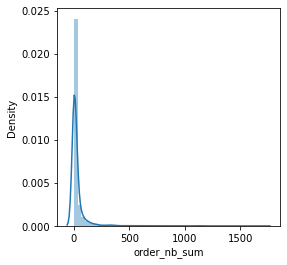

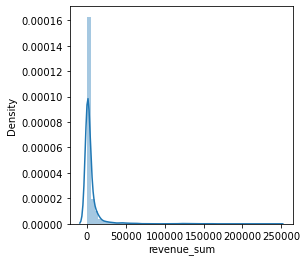

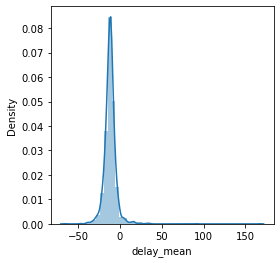

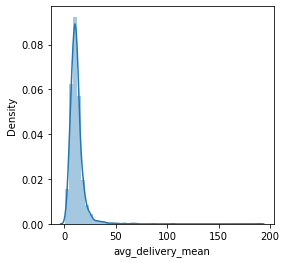

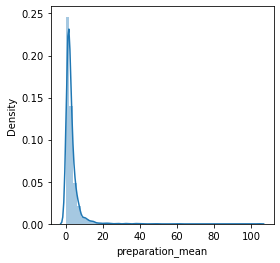

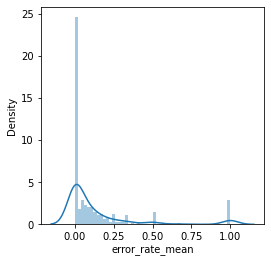

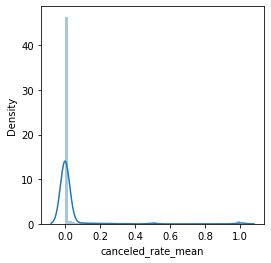

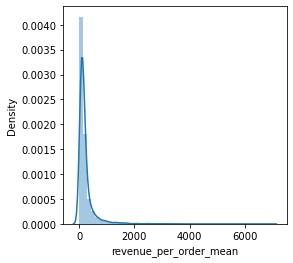

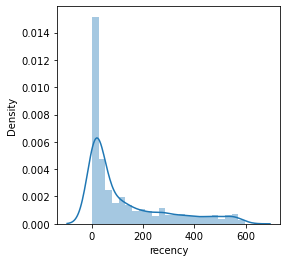

In [1253]:
for c in df_cluster[num_columns].columns:
    plt.figure(figsize = (4,4))
    sns.distplot(df_cluster[c])

In [1254]:
df_cluster.isnull().sum()

seller_id                 0  
geolocation_state_max     0  
order_nb_sum              0  
revenue_sum               0  
delay_mean                121
avg_delivery_mean         121
preparation_mean          115
error_rate_mean           0  
canceled_rate_mean        0  
revenue_per_order_mean    0  
recency                   0  
dtype: int64

In [1255]:
df_cluster_dropna = df_cluster.dropna(axis = 0, how = 'any')
df_cluster_dropna

,seller_id,geolocation_state_max,order_nb_sum,revenue_sum,delay_mean,avg_delivery_mean,preparation_mean,error_rate_mean,canceled_rate_mean,revenue_per_order_mean,recency
0,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,2748.06,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,316
1,001cca7ae9ae17fb1caed9dfb1094831,ES,198,33446.21,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,48
3,002100f778ceb8431b7a1020ff7ab48f,SP,44,1667.75,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,140
4,004c9cd9d87a3c30c522c48c4fc07416,SP,137,19214.56,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,120
5,00720abe85ba0859807595bbf045a33b,SP,11,1130.24,-5.595238,12.261905,3.833333,0.214286,0.000000,109.517619,26
...,...,...,...,...,...,...,...,...,...,...,...
2972,ffc470761de7d0232558ba5e786e57b7,SP,27,1959.92,-9.847222,9.634259,1.074074,0.083333,0.000000,76.492731,12
2974,ffdd9f82b9a447f6f8d4b91554cc7dd3,PR,18,2828.66,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,11
2975,ffeee66ac5d5a62fe688b9d26f83f534,SP,14,2259.55,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,108
2976,fffd5413c0700ac820c7069d66d98c89,SP,56,11530.83,-10.815942,13.760870,1.747101,0.177174,0.005435,213.903935,3


In [1256]:
df_cluster_model = df_cluster_dropna.drop(['seller_id','geolocation_state_max'], axis = 1)
df_cluster_model

,order_nb_sum,revenue_sum,delay_mean,avg_delivery_mean,preparation_mean,error_rate_mean,canceled_rate_mean,revenue_per_order_mean,recency
0,3,2748.06,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,316
1,198,33446.21,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,48
3,44,1667.75,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,140
4,137,19214.56,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,120
5,11,1130.24,-5.595238,12.261905,3.833333,0.214286,0.000000,109.517619,26
...,...,...,...,...,...,...,...,...,...
2972,27,1959.92,-9.847222,9.634259,1.074074,0.083333,0.000000,76.492731,12
2974,18,2828.66,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,11
2975,14,2259.55,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,108
2976,56,11530.83,-10.815942,13.760870,1.747101,0.177174,0.005435,213.903935,3


In [1257]:
df_cluster_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2857 entries, 0 to 2977
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_nb_sum            2857 non-null   int64  
 1   revenue_sum             2857 non-null   float64
 2   delay_mean              2857 non-null   float64
 3   avg_delivery_mean       2857 non-null   float64
 4   preparation_mean        2857 non-null   float64
 5   error_rate_mean         2857 non-null   float64
 6   canceled_rate_mean      2857 non-null   float64
 7   revenue_per_order_mean  2857 non-null   float64
 8   recency                 2857 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 223.2 KB


In [1258]:
# cluster 수 1~19개일 때 k-means clustering elbow값 확인하기
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_cluster_model)
    wcss.append(kmeans.inertia_)

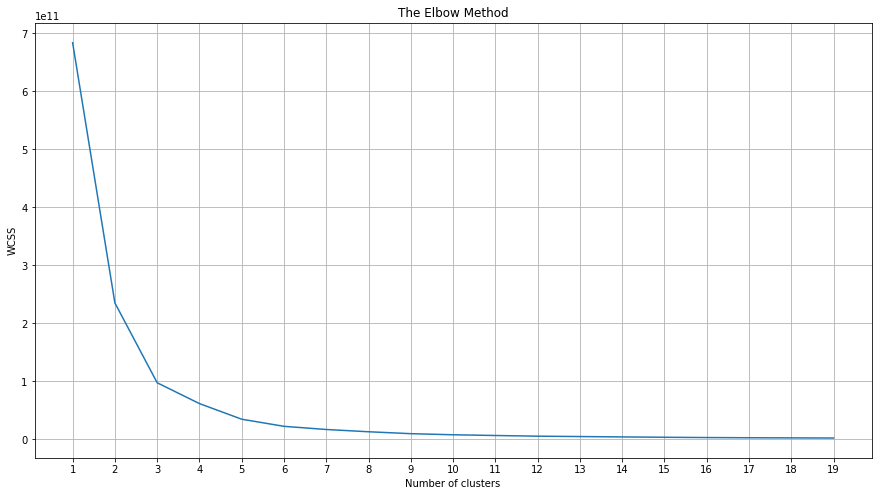

In [1259]:
plt.figure(figsize=(15,8))
plt.plot(range(1, 20), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()

In [1260]:
# n_cluster = 3 기준으로 진행
kmeans = KMeans(n_clusters=3, random_state = 42)
kmeans.fit(df_cluster_model)
kmeans.cluster_centers_

array([[ 1.86577304e+01,  2.68415800e+03, -1.17256092e+01,
         1.17421597e+01,  3.09128959e+00,  1.00167335e-01,
         9.55214731e-03,  2.17439492e+02,  1.25564818e+02],
       [ 9.33842105e+02,  1.58207792e+05, -1.18946657e+01,
         1.22557117e+01,  2.80948683e+00,  8.89459257e-02,
         3.59331936e-03,  2.19203983e+02,  1.10000000e+01],
       [ 2.12486957e+02,  3.80390325e+04, -1.23270846e+01,
         1.27687865e+01,  3.15402885e+00,  9.62791342e-02,
         4.00250968e-03,  3.96877600e+02,  2.91826087e+01]])

In [1261]:
# 라벨링 된 결과 확인
df_cluster_model['cluster'] = kmeans.labels_
df_cluster_model

,order_nb_sum,revenue_sum,delay_mean,avg_delivery_mean,preparation_mean,error_rate_mean,canceled_rate_mean,revenue_per_order_mean,recency,cluster
0,3,2748.06,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,316,0
1,198,33446.21,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,48,2
3,44,1667.75,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,140,0
4,137,19214.56,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,120,0
5,11,1130.24,-5.595238,12.261905,3.833333,0.214286,0.000000,109.517619,26,0
...,...,...,...,...,...,...,...,...,...,...
2972,27,1959.92,-9.847222,9.634259,1.074074,0.083333,0.000000,76.492731,12,0
2974,18,2828.66,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,11,0
2975,14,2259.55,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,108,0
2976,56,11530.83,-10.815942,13.760870,1.747101,0.177174,0.005435,213.903935,3,0


In [1262]:
df_cluster_model = pd.concat([df_cluster_dropna['seller_id'], df_cluster_model], axis = 1)
df_cluster_model

,seller_id,order_nb_sum,revenue_sum,delay_mean,avg_delivery_mean,preparation_mean,error_rate_mean,canceled_rate_mean,revenue_per_order_mean,recency,cluster
0,0015a82c2db000af6aaaf3ae2ecb0532,3,2748.06,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,316,0
1,001cca7ae9ae17fb1caed9dfb1094831,198,33446.21,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,48,2
3,002100f778ceb8431b7a1020ff7ab48f,44,1667.75,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,140,0
4,004c9cd9d87a3c30c522c48c4fc07416,137,19214.56,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,120,0
5,00720abe85ba0859807595bbf045a33b,11,1130.24,-5.595238,12.261905,3.833333,0.214286,0.000000,109.517619,26,0
...,...,...,...,...,...,...,...,...,...,...,...
2972,ffc470761de7d0232558ba5e786e57b7,27,1959.92,-9.847222,9.634259,1.074074,0.083333,0.000000,76.492731,12,0
2974,ffdd9f82b9a447f6f8d4b91554cc7dd3,18,2828.66,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,11,0
2975,ffeee66ac5d5a62fe688b9d26f83f534,14,2259.55,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,108,0
2976,fffd5413c0700ac820c7069d66d98c89,56,11530.83,-10.815942,13.760870,1.747101,0.177174,0.005435,213.903935,3,0


In [1263]:
df_cluster = df_cluster.merge(df_cluster_model, on = 'seller_id', how = 'left')
df_cluster

,seller_id,geolocation_state_max,order_nb_sum_x,revenue_sum_x,delay_mean_x,avg_delivery_mean_x,preparation_mean_x,error_rate_mean_x,canceled_rate_mean_x,revenue_per_order_mean_x,recency_x,order_nb_sum_y,revenue_sum_y,delay_mean_y,avg_delivery_mean_y,preparation_mean_y,error_rate_mean_y,canceled_rate_mean_y,revenue_per_order_mean_y,recency_y,cluster
0,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,2748.06,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,316,3.0,2748.06,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,316.0,0.0
1,001cca7ae9ae17fb1caed9dfb1094831,ES,198,33446.21,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,48,198.0,33446.21,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,48.0,2.0
2,001e6ad469a905060d959994f1b41e4f,RJ,1,267.94,NaN,NaN,NaN,1.000000,1.000000,267.940000,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,002100f778ceb8431b7a1020ff7ab48f,SP,44,1667.75,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,140,44.0,1667.75,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,140.0,0.0
4,004c9cd9d87a3c30c522c48c4fc07416,SP,137,19214.56,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,120,137.0,19214.56,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,120.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,ffcfefa19b08742c5d315f2791395ee5,PR,1,79.52,NaN,NaN,NaN,1.000000,1.000000,79.520000,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2974,ffdd9f82b9a447f6f8d4b91554cc7dd3,PR,18,2828.66,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,11,18.0,2828.66,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,11.0,0.0
2975,ffeee66ac5d5a62fe688b9d26f83f534,SP,14,2259.55,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,108,14.0,2259.55,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,108.0,0.0
2976,fffd5413c0700ac820c7069d66d98c89,SP,56,11530.83,-10.815942,13.760870,1.747101,0.177174,0.005435,213.903935,3,56.0,11530.83,-10.815942,13.760870,1.747101,0.177174,0.005435,213.903935,3.0,0.0


In [1264]:
df_cluster.loc[df_cluster['cluster'].isnull(), 'cluster'] = 3
df_cluster

,seller_id,geolocation_state_max,order_nb_sum_x,revenue_sum_x,delay_mean_x,avg_delivery_mean_x,preparation_mean_x,error_rate_mean_x,canceled_rate_mean_x,revenue_per_order_mean_x,recency_x,order_nb_sum_y,revenue_sum_y,delay_mean_y,avg_delivery_mean_y,preparation_mean_y,error_rate_mean_y,canceled_rate_mean_y,revenue_per_order_mean_y,recency_y,cluster
0,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,2748.06,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,316,3.0,2748.06,-18.000000,10.250000,2.750000,0.000000,0.000000,916.020000,316.0,0.0
1,001cca7ae9ae17fb1caed9dfb1094831,ES,198,33446.21,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,48,198.0,33446.21,-13.009793,13.885837,2.422261,0.112501,0.000000,169.877521,48.0,2.0
2,001e6ad469a905060d959994f1b41e4f,RJ,1,267.94,NaN,NaN,NaN,1.000000,1.000000,267.940000,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,002100f778ceb8431b7a1020ff7ab48f,SP,44,1667.75,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,140,44.0,1667.75,-7.983036,15.467857,3.146131,0.232440,0.000000,41.180753,140.0,0.0
4,004c9cd9d87a3c30c522c48c4fc07416,SP,137,19214.56,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,120,137.0,19214.56,-13.284333,13.069757,1.155570,0.071192,0.000000,141.287957,120.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,ffcfefa19b08742c5d315f2791395ee5,PR,1,79.52,NaN,NaN,NaN,1.000000,1.000000,79.520000,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2974,ffdd9f82b9a447f6f8d4b91554cc7dd3,PR,18,2828.66,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,11,18.0,2828.66,-13.015152,9.696970,3.287879,0.000000,0.000000,149.681515,11.0,0.0
2975,ffeee66ac5d5a62fe688b9d26f83f534,SP,14,2259.55,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,108,14.0,2259.55,-6.500000,18.202381,7.583333,0.214286,0.000000,159.352857,108.0,0.0
2976,fffd5413c0700ac820c7069d66d98c89,SP,56,11530.83,-10.815942,13.760870,1.747101,0.177174,0.005435,213.903935,3,56.0,11530.83,-10.815942,13.760870,1.747101,0.177174,0.005435,213.903935,3.0,0.0


In [1266]:
clustering = df_cluster[['seller_id', 'cluster']]
clustering

,seller_id,cluster
0,0015a82c2db000af6aaaf3ae2ecb0532,0.0
1,001cca7ae9ae17fb1caed9dfb1094831,2.0
2,001e6ad469a905060d959994f1b41e4f,3.0
3,002100f778ceb8431b7a1020ff7ab48f,0.0
4,004c9cd9d87a3c30c522c48c4fc07416,0.0
...,...,...
2973,ffcfefa19b08742c5d315f2791395ee5,3.0
2974,ffdd9f82b9a447f6f8d4b91554cc7dd3,0.0
2975,ffeee66ac5d5a62fe688b9d26f83f534,0.0
2976,fffd5413c0700ac820c7069d66d98c89,0.0


### df_final, clustering 데이터셋 합치기

In [1269]:
df_final_clustered = df_final.merge(clustering, on = 'seller_id', how = 'left')
df_final_clustered

,seller_id,geolocation_state,delay,avg_delivery,preparation,error_rate,canceled_rate,revenue_per_order,cluster
0,0015a82c2db000af6aaaf3ae2ecb0532,SP,-23.000000,10.000000,2.000000,0.000000,0.00,916.020000,0.0
1,0015a82c2db000af6aaaf3ae2ecb0532,SP,-13.000000,10.500000,3.500000,0.000000,0.00,916.020000,0.0
2,001cca7ae9ae17fb1caed9dfb1094831,ES,-18.200000,15.800000,2.600000,0.000000,0.00,259.080000,2.0
3,001cca7ae9ae17fb1caed9dfb1094831,ES,-10.636364,12.818182,2.636364,0.090909,0.00,193.090909,2.0
4,001cca7ae9ae17fb1caed9dfb1094831,ES,-13.416667,11.916667,1.076923,0.153846,0.00,159.130000,2.0
...,...,...,...,...,...,...,...,...,...
21912,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,0.25,154.545000,0.0
21913,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,1.00,126.690000,0.0
21914,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,0.00,70.535000,0.0
21915,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,0.50,48.300000,0.0


# 모형을 통한 예측 (w cluster)

## cluster 컬럼 추가

In [1273]:
df_final_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21917 entries, 0 to 21916
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seller_id          21917 non-null  object 
 1   geolocation_state  21917 non-null  object 
 2   delay              21438 non-null  float64
 3   avg_delivery       21438 non-null  float64
 4   preparation        21544 non-null  float64
 5   error_rate         21917 non-null  float64
 6   canceled_rate      21917 non-null  float64
 7   revenue_per_order  21917 non-null  float64
 8   cluster            21917 non-null  float64
dtypes: float64(7), object(2)
memory usage: 1.7+ MB


In [1282]:
df_final_clustered['cluster'] = df_final_clustered['cluster'].astype(object)

In [1283]:
cat_columns = [c for c, t in zip(df_final_clustered.dtypes.index, df_final_clustered.dtypes) if t == 'O']
num_columns = [c for c in df_final_clustered.columns if c not in cat_columns]
print('Categorical Columns:\n{}\n\n Numeric Columns:\n{}\n'.format(cat_columns, num_columns))

Categorical Columns:
['seller_id', 'geolocation_state', 'cluster']

 Numeric Columns:
['delay', 'avg_delivery', 'preparation', 'error_rate', 'canceled_rate', 'revenue_per_order']



In [1284]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_final_clustered, label, test_size=0.3,
                                                       random_state=2021,
                                                       shuffle=True)

In [1285]:
x_train.shape, x_test.shape

((15341, 9), (6576, 9))

In [1286]:
# 연속형 변수 처리x
x_train, x_test = preprocess(x_train, x_test)

In [1287]:
x_train.shape, x_test.shape

((15341, 3009), (6576, 3009))

In [1288]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

models = [['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

XGBoost Model MAE : 0.2076388318055734
XGBoost Model RMSE: 0.2893345956327563
LightGBM Model MAE : 0.2079786945724442
LightGBM Model RMSE: 0.28828235397349516
Best Model: LightGBM, RMSE: 0.28828235397349516


In [1280]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
print('r2_score : {:.3f}'.format(r2_score(y_test, y_pred)))
print('MAE      : {:.6f}'.format(mean_absolute_error(y_test, y_pred)))
print('MSE      : {:.6f}'.format(mean_squared_error(y_test, y_pred)))
print('RMSE     : {:.6f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

r2_score : 0.247
MAE      : 0.207841
MSE      : 0.083133
RMSE     : 0.288328


## cluster 컬럼 삭제

In [1289]:
testing = df_final_clustered.drop('cluster', axis = 1)
testing

,seller_id,geolocation_state,delay,avg_delivery,preparation,error_rate,canceled_rate,revenue_per_order
0,0015a82c2db000af6aaaf3ae2ecb0532,SP,-23.000000,10.000000,2.000000,0.000000,0.00,916.020000
1,0015a82c2db000af6aaaf3ae2ecb0532,SP,-13.000000,10.500000,3.500000,0.000000,0.00,916.020000
2,001cca7ae9ae17fb1caed9dfb1094831,ES,-18.200000,15.800000,2.600000,0.000000,0.00,259.080000
3,001cca7ae9ae17fb1caed9dfb1094831,ES,-10.636364,12.818182,2.636364,0.090909,0.00,193.090909
4,001cca7ae9ae17fb1caed9dfb1094831,ES,-13.416667,11.916667,1.076923,0.153846,0.00,159.130000
...,...,...,...,...,...,...,...,...
21912,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,0.25,154.545000
21913,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,1.00,126.690000
21914,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,0.00,70.535000
21915,ffff564a4f9085cd26170f4732393726,SP,NaN,NaN,NaN,1.000000,0.50,48.300000


In [1291]:
cat_columns = [c for c, t in zip(testing.dtypes.index, testing.dtypes) if t == 'O']
num_columns = [c for c in testing.columns if c not in cat_columns]
print('Categorical Columns:\n{}\n\n Numeric Columns:\n{}\n'.format(cat_columns, num_columns))

Categorical Columns:
['seller_id', 'geolocation_state']

 Numeric Columns:
['delay', 'avg_delivery', 'preparation', 'error_rate', 'canceled_rate', 'revenue_per_order']



In [1292]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(testing, label, test_size=0.3,
                                                       random_state=2021,
                                                       shuffle=True)

In [1293]:
x_train.shape, x_test.shape

((15341, 8), (6576, 8))

In [1294]:
# 연속형 변수 처리x
x_train, x_test = preprocess(x_train, x_test)
x_train.shape, x_test.shape

((15341, 3005), (6576, 3005))

In [1295]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

models = [['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

XGBoost Model MAE : 0.20799241529719684
XGBoost Model RMSE: 0.2893276482968256
LightGBM Model MAE : 0.20775722393750834
LightGBM Model RMSE: 0.28811021209894283
Best Model: LightGBM, RMSE: 0.28811021209894283


# Cross Validation (w/o cluster)

In [1304]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2021)

In [1306]:
for i, (trn_idx, val_idx) in enumerate(kf.split(testing, label)):
    x_train, y_train = testing.iloc[trn_idx, :], label[trn_idx]
    x_test, y_test = testing.iloc[val_idx, :], label[val_idx]

In [1313]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

val_scores = list()

kf = KFold(n_splits=5, shuffle=True, random_state=2021)

for i, (trn_idx, val_idx) in enumerate(kf.split(testing, label)):
    x_train, y_train = testing.iloc[trn_idx], label[trn_idx]
    x_test, y_test = testing.iloc[val_idx], label[val_idx]
    
    # 전처리
    x_train, x_test = preprocess(x_train, x_test)
    
    # 모델 정의
    lgbm = LGBMRegressor(random_state=2021, n_jobs=-1)
    
    # 모델 학습
    lgbm.fit(x_train, y_train)
    y_pred = lgbm.predict(x_test)
    
    # 훈련, 검증 데이터 RMSE 확인
    trn_rmse = np.sqrt(mean_squared_error(y_true = y_train, y_pred = lgbm.predict(x_train)))
    val_rmse = np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred))
    print('{} Fold, train rmse_score : {:.4f}, validation rmse_score : {:.4f}'.format(i, trn_rmse, val_rmse))
    
    val_scores.append(val_rmse)

# 교차 검증 rmse_score 평균 계산하기
print('Cross Validation Score : {:.4f}'.format(np.mean(val_scores)))

0 Fold, train rmse_score : 0.2728, validation rmse_score : 0.2878
1 Fold, train rmse_score : 0.2697, validation rmse_score : 0.2946
2 Fold, train rmse_score : 0.2703, validation rmse_score : 0.2926
3 Fold, train rmse_score : 0.2696, validation rmse_score : 0.2962
4 Fold, train rmse_score : 0.2708, validation rmse_score : 0.2899
Cross Validation Score : 0.2922


In [1324]:
lgbm.feature_importances_

array([524, 494, 384, ...,  16,   0,  65])

In [1325]:
lgbm.max_depth

-1

In [1326]:
lgbm.learning_rate

0.1

In [1327]:
lgbm.n_estimators

100

# Hyperparameter Tuning

In [1362]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
params = {'n_estimators':[55, 60, 65],
          'max_depth':[3, 4],
         'learning_rate' : [0.08]}

lgbm_tuning = GridSearchCV(LGBMRegressor(random_state=2021), 
                   params, n_jobs= 5, scoring='neg_root_mean_squared_error')

In [1363]:
lgbm_tuning.fit(x_train, y_train)

GridSearchCV(estimator=LGBMRegressor(random_state=2021), n_jobs=5,
             param_grid={'learning_rate': [0.08], 'max_depth': [3, 4],
                         'n_estimators': [55, 60, 65]},
             scoring='neg_root_mean_squared_error')

In [1366]:
print('GridSearchCV best mse score : {:.4f}, best_params : {}'.format(-lgbm_tuning.best_score_, lgbm_tuning.best_params_))

GridSearchCV best mse score : 0.2908, best_params : {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 65}


In [1367]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

val_scores = list()

kf = KFold(n_splits=5, shuffle=True, random_state=2021)

for i, (trn_idx, val_idx) in enumerate(kf.split(testing, label)):
    x_train, y_train = testing.iloc[trn_idx], label[trn_idx]
    x_test, y_test = testing.iloc[val_idx], label[val_idx]
    
    # 전처리
    x_train, x_test = preprocess(x_train, x_test)
    
    # 모델 정의
    lgbm = LGBMRegressor(random_state=2021, n_jobs=-1, learning_rate = 0.08, max_depth = 3, n_estimators = 65)
    
    # 모델 학습
    lgbm.fit(x_train, y_train)
    y_pred = lgbm.predict(x_test)
    
    # 훈련, 검증 데이터 RMSE 확인
    trn_rmse = np.sqrt(mean_squared_error(y_true = y_train, y_pred = lgbm.predict(x_train)))
    val_rmse = np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred))
    print('{} Fold, train rmse_score : {:.4f}, validation rmse_score : {:.4f}'.format(i, trn_rmse, val_rmse))
    
    val_scores.append(val_rmse)

# 교차 검증 rmse_score 평균 계산하기
print('Cross Validation Score : {:.4f}'.format(np.mean(val_scores)))

0 Fold, train rmse_score : 0.2888, validation rmse_score : 0.2855
1 Fold, train rmse_score : 0.2871, validation rmse_score : 0.2934
2 Fold, train rmse_score : 0.2876, validation rmse_score : 0.2905
3 Fold, train rmse_score : 0.2868, validation rmse_score : 0.2938
4 Fold, train rmse_score : 0.2881, validation rmse_score : 0.2879
Cross Validation Score : 0.2902
